<div class="alert alert-block alert-success">
    
# Task 3 Exploratory Data Analysis (EDA) Report: Extended Version
#### Name: Zihan Yin

Date: 2025.11.21

Environment: Python 3.10.16

Libraries used:
* json
* pandas
* numpy
* collections
* plotnine
    
</div>

<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[Introduction](#0) <br>
[Step 0: Optimized Data Loading & Preparation (Replaces Original Steps 0 - 1.1.2)](#1) <br>
[Step 1: Understand the Sample Google Review Data](#1) <br>
$\;\;\;\;$[1.2 Summarising for `gmap_info`](#1.2) <br>
$\;\;\;\;$[1.3 Summarising for `gmap_reviews`](#1.3) <br>
$\;\;\;\;$[1.4 Preliminary Trends and Patterns](#1.4) <br>
[Step 2: Understand the Metadata](#2) <br>
$\;\;\;\;$[2.1 Metadata Overview](#2.1) <br>
$\;\;\;\;$[2.2 Processing & Feature Engineering](#2.2) <br>
$\;\;\;\;$[2.3 Evaluate the Usefulness](#2.3) <br>
[Step 3: Data Analysis](#3) <br>
$\;\;\;\;$[3.1 Analyzing from the Business Perspective](#3.1) <br>
$\;\;\;\;$[3.2 Analyzing from the User Perspective](#3.2) <br>
[Step 4: Summary of Meaningful Insights](#4) <br>


# Introduction

In this task, we conduct a comprehensive exploratory data analysis (EDA) on the provided Google Review data & metadata. The goal is to uncover interesting insights that can be useful for further analysis or decision-making. The whole `.ipynb` is divided into 4 steps.

<div class="alert alert-block alert-success">

# Step 0: Optimized Data Loading & Preparation (Replaces Original Steps 0 - 1.1.2) <a id='optimized_loading'></a>

</div>

**背景与重构原理 (Context & Rationale):**
本节作为一个整合且高性能的替代方案，取代了原始的 **Step 0**、**Step 1.1.1** 和 **Step 1.1.2**。

从单个样本组 (Group 020) 过渡到完整数据集 (200 个组，约 2.8GB) 引入了关键的可扩展性挑战，必须进行如下重构：

1.  **内存瓶颈 (`explode` 问题):** 原始方法加载巨大的嵌套 JSON 文件并使用 `df.explode('reviews')`，随后是 `apply(pd.Series)`。这种操作计算成本极高，导致内存使用激增 (通常超过 32GB)，在处理完整数据集时会导致内存溢出 (OOM) 崩溃。
2.  **I/O 性能:** 解析 2GB+ 的 JSON 文件明显慢于读取优化后的二进制格式。
3.  **数据一致性:** Task 1 生成的聚合 CSV 缺少 `earliest_review_date` 和 `latest_review_date` 列。与其解析巨大的 JSON 来获取它们，直接从详细评论数据中重新计算要快得多且更准确。

**本节工作流程 (Workflow in this Section):**
为了确保稳定性和速度，本节实施了以下优化管道：
* **极速加载:** 直接从内存映射的 **Feather 格式 (`.ftr`)** (Task 1 生成) 加载聚合指标 (`.csv`) 和详细评论记录。这将加载时间从几分钟缩短到了几秒钟。
* **动态日期聚合:** 对详细评论数据执行快速的 `groupby` 操作来重新计算 `earliest_review_date` 和 `latest_review_date`，并将结果合并回商家信息 (`gmap_info`)。
* **特征工程:** 直接在扁平化的 DataFrame 上重新实现 `n_pictures` 和 `len_review_text` 列的创建。
* **索引恢复:** 设置 `MultiIndex` (gmap_id, user_id) 以确保与后续分析代码 (Step 1.2 及之后) 完全兼容。

In [ ]:
# ==============================================================================
# Replacement for: Step 0 to Step 1.1.2
# 整合了数据加载、日期修复、特征工程和索引设置
# ==============================================================================

# --- 0.1 Importing Libraries ---
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from plotnine import *
import os
import ast

# --- 0.2 Importing Data (Fast Loading Strategy) ---

# Windows UNC 路径辅助函数
def get_unc_path(path):
    abs_path = os.path.abspath(path)
    if os.name == 'nt' and not abs_path.startswith('\\\\?\\'):
        return '\\\\?\\' + abs_path.replace('/', '\\')
    return abs_path

# 路径配置
base_output_path = '../01_data/02_data_wrangled/'
base_raw_path = '../01_data/01_data_raw/'

csv_path = os.path.join(get_unc_path(base_output_path), 'Task1_for_GroupALL.csv')
ftr_path = os.path.join(get_unc_path(base_output_path), 'Task1_for_GroupALL_DETAIL.ftr')
metadata_path = os.path.join(get_unc_path(base_raw_path), 'meta-California.json')

print("🚀 [Step 1] 开始极速加载数据...")

# 1. 加载 Metadata
metadata = pd.read_csv(metadata_path) if metadata_path.endswith('.csv') else pd.read_json(metadata_path, lines=True)
print(f"Metadata 加载完成: {metadata.shape}")

# 2. 加载详细评论 (gmap_reviews) - Feather 格式
gmap_reviews = pd.read_feather(ftr_path)
print(f"详细评论 (gmap_reviews) 加载完成: {gmap_reviews.shape}")

# 3. 加载聚合信息 (gmap_info) - CSV 格式 (只有计数，缺少日期)
gmap_info = pd.read_csv(csv_path)
print(f"聚合信息 (gmap_info) 加载完成: {gmap_info.shape}")


# --- 1.1 Data Integration & Feature Engineering ---

print("\n🚀 [Step 2] 执行数据补全与特征工程...")

# === A. 修复缺失的日期列 (关键步骤) ===
# 不去读那个巨大的 JSON，而是直接从详细评论中计算 min/max 时间
# 这既快又准
print("正在从详细评论中计算最早/最晚评论时间...")
date_stats = gmap_reviews.groupby('gmap_id')['time'].agg(['min', 'max'])
date_stats.columns = ['earliest_review_date', 'latest_review_date']

# 将计算出的日期合并到 gmap_info 中
gmap_info = pd.merge(gmap_info, date_stats, on='gmap_id', how='left')

# 确保日期类型正确
gmap_info['earliest_review_date'] = pd.to_datetime(gmap_info['earliest_review_date'])
gmap_info['latest_review_date'] = pd.to_datetime(gmap_info['latest_review_date'])


# === B. gmap_reviews 特征工程 ===

# 1. 处理 pic_dim 和 n_pictures
# Feather 存储 pic_dim 为字符串，需要解析回列表
# 如果 pic_dim 是 None，视为 '[]'
print("正在处理图片维度信息...")
gmap_reviews['pic_dim'] = gmap_reviews['pic_dim'].fillna('[]').apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
# 计算图片数量
gmap_reviews['n_pictures'] = gmap_reviews['pic_dim'].apply(len)
# 移除不再需要的列
gmap_reviews = gmap_reviews.drop(['if_pic', 'pic_dim'], axis=1)

# 2. 处理 review_text 的缺失值和长度
print("正在处理文本长度...")
# Task 1 新逻辑中，空值可能是 NaN 或 None，统一填充为空字符串
gmap_reviews['review_text'] = gmap_reviews['review_text'].fillna("")
# 计算单词数量
gmap_reviews['len_review_text'] = gmap_reviews['review_text'].apply(lambda x: len(str(x).split()))

# 3. 确保时间列类型
gmap_reviews['time'] = pd.to_datetime(gmap_reviews['time'])


# === C. 设置索引 (Task 3 要求的格式) ===

print("\n🚀 [Step 3] 设置索引...")

# 设置 gmap_info 索引
gmap_info = gmap_info.set_index('gmap_id')

# 设置 gmap_reviews 多级索引
gmap_reviews = gmap_reviews.set_index(['gmap_id', 'user_id'])

# === D. 最终验证 ===
print("-" * 30)
print("数据准备就绪！")
print(f"gmap_info Shape: {gmap_info.shape}")
print(f"gmap_reviews Shape: {gmap_reviews.shape}")
print("-" * 30)

# 展示前几行供检查
print("gmap_info 预览:")
display(gmap_info.head(3))
print("gmap_reviews 预览:")
display(gmap_reviews[['review_text', 'len_review_text', 'n_pictures']].head(3))

🚀 [Step 1] 开始极速加载数据...
Metadata 加载完成: (515961, 15)
详细评论 (gmap_reviews) 加载完成: (5767463, 13)
聚合信息 (gmap_info) 加载完成: (29088, 4)

🚀 [Step 2] 执行数据补全与特征工程...
正在从详细评论中计算最早/最晚评论时间...
正在处理图片维度信息...
正在处理文本长度...

🚀 [Step 3] 设置索引...
------------------------------
数据准备就绪！
gmap_info Shape: (29088, 5)
gmap_reviews Shape: (5767463, 11)
------------------------------
gmap_info 预览:


,review_count,review_text_count,response_count,earliest_review_date,latest_review_date
gmap_id,,,,,
0x14e01eb3852caf59:0x381f9a958435f502,68,29,0,2015-12-30 01:30:31,2021-05-17 21:05:27
0x14e036ddeb07f8e7:0x52211982ce605a81,68,27,0,2015-03-09 02:11:28,2021-03-31 09:12:35
0x14e177e66ec01f79:0x11d08fd54eebed7e,128,113,43,2016-05-26 11:33:41,2021-06-17 17:12:46


gmap_reviews 预览:


review_text  \
gmap_id                               user_id                                                                    
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877  We met with friends at this restaurant for din...   
                                      103079253096551262298  Best place on earth !!! Good staff cool little...   
                                      103122076323828911215          Awesome bar. Great vibe. Fantastic folks.   

                                                             len_review_text  \
gmap_id                               user_id                                  
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877               54   
                                      103079253096551262298               14   
                                      103122076323828911215                6   

                                                             n_pictures  
gmap_id                               user_id                            
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877           0  
                                      103079253096551262298           1  
                                      103122076323828911215           0

<div class="alert alert-block alert-info">

## 数据规模分析：从样本 (Group 020) 到总体 (Group All)

</div>

**扩展概览 (Overview of the Expansion):**
从单组样本 (Group 020) 到完整数据集 (Group All) 的过渡标志着项目数据规模的显著扩展。分析范围已从局部样本延伸至加州市场中具有代表性的数据集。

下表总结了数据量的变化情况：

| 指标 (Metric) | Group 020 (样本) | Group All (全量数据) | 增长倍数 (Growth Factor) |
| :--- | :--- | :--- | :--- |
| **商铺数 (`gmap_info`)** | 176 | **29,088** | **165x** |
| **评论数 (`gmap_reviews`)** | 35,275 | **5,767,463** | **163x** |
| **唯一用户数** | 34,921 | **3,457,903** | **99x** |
| **人均评论数 (Avg)** | 1.01 | **1.67** | -- |
| **加州元数据覆盖率** | 0.03% | **5.64%** | -- |

**核心架构与分析启示 (Key Architectural & Analytical Implications):**

1.  **跨越“大数据”门槛:**
    数据集包含超过 **570 万条评论**，其规模已超出常规内存 JSON 解析的处理能力。这一事实验证了我们在 Task 3 中将架构调整为 **Feather (`.ftr`)** 格式和内存映射 (Memory-mapped I/O) 的必要性。

2.  **数据稀疏性降低与推荐系统可行性 (Crucial for App 2):**
    对比数据显示：**评论数增长了 163 倍，而用户数增长了 99 倍。**
    * **现象:** 用户增长倍数低于评论增长倍数。
    * **原因:** 在全量数据中，更多用户在不同商家留下了评论，相比单组样本，数据稀疏性有所降低。
    * **价值:** 人均评论数提升至 **1.67** 为 **App 2 (协同过滤推荐系统)** 提供了必要的 User-Item 交互基础。相比 1:1 的稀疏关系，当前的密度能更有效地支持协同过滤算法的构建。

3.  **统计显著性:**
    当前数据集覆盖了加州全量元数据的 **5.6%** (29,088 / 515,961)。570 万的样本量为后续训练 **多模态分类器 (App 1)** 和 **大语言模型 (App 5)** 提供了充足的数据支持，有助于提升模型在真实场景中的泛化能力。

<div class="alert alert-block alert-info">

## 附录：原始数据处理流程回顾 (Step 0 - 1.1.2) <a id='legacy_processing'></a>

</div>

我依然保留了原本的 Steps 0 - 1.1.2 处理步骤的描述，来方便查看原本进行了哪些步骤，以此来与后续的旧代码对齐。  
 - 如果你对此不感兴趣，可以直接跳转到 Step 1.2。  
 - 如果你想要查看详细的代码，可以参考 `Task2_EDA_Report_Original_VR.ipynb`



**说明：** 本节总结了在单组数据 (Group 020) 分析中使用的原始数据处理流程。由于该流程在处理全量数据 (200组) 时存在严重的内存瓶颈（主要源于 JSON 解析与 `explode` 操作），在当前版本中已被前述的 **[Step New: Optimized Data Loading](#optimized_loading)** 所取代。在此保留以供参考。

**被替换掉的原始section目录如下所示：**

[Step 0: Preparation](#0) <br>
$\;\;\;\;$[0.1 Importing Libraries](#0.1) <br>
$\;\;\;\;$[0.2 Importing Data](#0.2) <br>
$\;\;\;\;\;\;\;\;$[0.2.1 Import Google Maps review data](#0.2.1) <br>
$\;\;\;\;\;\;\;\;$[0.2.2 Import metadata](#0.2.2) <br>
[Step 1: Understand the Sample Google Review Data](#1) <br>
$\;\;\;\;$[1.1 Processing for Subsequent Analysis](#1.1) <br>
$\;\;\;\;\;\;\;\;$[1.1.1 Data Integration & Split](#1.1.1) <br>
$\;\;\;\;\;\;\;\;$[1.1.2 Converting Data Type & Simple Feature Engineering](#1.1.2) <br>

### Step 0: 准备工作 (Preparation)
#### 0.1 库导入 (Libraries)
使用了 `json`, `pandas`, `numpy`, `collections`, `plotnine` 等基础数据科学库。

#### 0.2 数据导入 (Data Loading)
原始流程分别读取了三种格式的文件：
* **聚合数据:** `task1_020.csv` (Task 1 生成的基础统计)。
* **原始嵌套数据:** `task1_020.json` (包含完整的评论文本和元数据，这是导致后续内存溢出的根源)。
* **元数据:** `meta-California.json` (用于补充商家信息)。

### Step 1: 原始数据整合与清洗 (Data Integration & Cleaning)
#### 1.1.1 数据拆分与重组 (Integration & Split)
* **合并 (Merge):** 将 CSV 和 JSON 数据基于 `gmap_id` 合并，形成初始的 `gmap_info`。
* **展开 (Explode - 性能瓶颈点):**
    * 对 `gmap_info` 中的 `reviews` 列执行 `explode` 操作。
    * 使用 `apply(pd.Series)` 将字典列展平。
* **双表架构 (Dual DataFrame Structure):**
    1.  **`gmap_info` (商家表):** 索引为 `gmap_id`。包含 `review_count`, `response_count` 及日期范围等商家级指标。
    2.  **`gmap_reviews` (评论表):** 索引为 `(gmap_id, user_id)`。包含具体的 `review_text`, `rating`, `time` 等评论级数据。
* **唯一性检查:** 验证了索引的唯一性。

#### 1.1.2 特征工程 (Feature Engineering)
在原始流程中，以下转换是在 Pandas 中在线计算的（现在已部分移至 ETL 阶段或优化为向量化操作）：
1.  **类型转换:** 将 `time`, `earliest_review_date`, `latest_review_date` 转换为 `datetime` 对象。
2.  **图片统计 (`n_pictures`):** 将 `pic_dim` (图片尺寸列表) 转换为列表长度，表示评论包含的图片数量。
3.  **缺失值清洗:** 将文本列中的字符串 `"None"` 替换为 Pandas 友好的 `NaN` 或空字符串 `""`。
4.  **文本长度 (`len_review_text`):** 计算 `review_text` 的单词数量 (Word Count)。

<div class="alert alert-block alert-success">

# Step 1: Understand the Sample Google Review Data <a id='optimized_loading'></a>

</div>

Welcome back，可由新的 Step 0 直接跳转到此处进行阅读。

## 1.2 Summarising for `gmap_info`

In this section, we focus on the univariate analysis of the `gmap_info` dataset. Specifically, we examine the distribution of each column.

In [8]:
# Print the number of records in the 'gmap_info' DataFrame
print(f'The number of records: {len(gmap_info)}')

# Display the first 5 rows of the 'gmap_info' DataFrame
gmap_info.head(5)

The number of records: 29088


,review_count,review_text_count,response_count,earliest_review_date,latest_review_date
gmap_id,,,,,
0x14e01eb3852caf59:0x381f9a958435f502,68,29,0,2015-12-30 01:30:31,2021-05-17 21:05:27
0x14e036ddeb07f8e7:0x52211982ce605a81,68,27,0,2015-03-09 02:11:28,2021-03-31 09:12:35
0x14e177e66ec01f79:0x11d08fd54eebed7e,128,113,43,2016-05-26 11:33:41,2021-06-17 17:12:46
0x14e19dbfedc0c44b:0xe507b98095e6f001,102,72,1,2015-09-12 06:57:01,2021-06-06 05:42:53
0x14e19f36dc395749:0xd860865200fa942d,108,64,1,2015-04-21 15:28:40,2021-05-28 17:53:50


The following statistics show:
- `review_count`, `review_text_count`, and `response_count` all exhibit strong right-skewed distributions, especially `response_count`, with a median of 0.
- The most of `latest_review_date` values are concentrated in recent years, while `earliest_review_date` values are generally distributed further in the past.

These statistical summaries are not very intuitive, so we create some visualizations to better understand the data.

In [9]:
# Generate descriptive statistics for the 'gmap_info' DataFrame
gmap_info.describe()

,review_count,review_text_count,response_count,earliest_review_date,latest_review_date
count,29088.000000,29088.000000,29088.000000,29088,29088
mean,198.276368,115.238621,29.263786,2015-01-06 13:52:30.659584768,2021-04-08 17:18:48.313394176
min,18.000000,8.000000,0.000000,1990-12-31 00:00:00,2014-11-21 22:45:33
25%,68.000000,42.000000,0.000000,2013-03-01 14:32:12,2021-05-04 19:49:30.500000
50%,98.000000,62.000000,0.000000,2015-02-22 17:42:54,2021-05-23 23:30:01.500000
75%,176.000000,107.000000,18.000000,2016-09-08 17:04:08.500000,2021-06-05 01:21:33
max,9998.000000,8669.000000,4941.000000,2021-08-06 15:26:36,2021-09-08 21:36:49
std,403.110858,228.046505,116.803646,NaN,NaN


Since `review_count`, `review_text_count`, and `response_count` are all related to the number of reviews/responses, we can overlay them in a single visualization. Below is the histogram for `review_count`, `review_text_count`, and `response_count`.

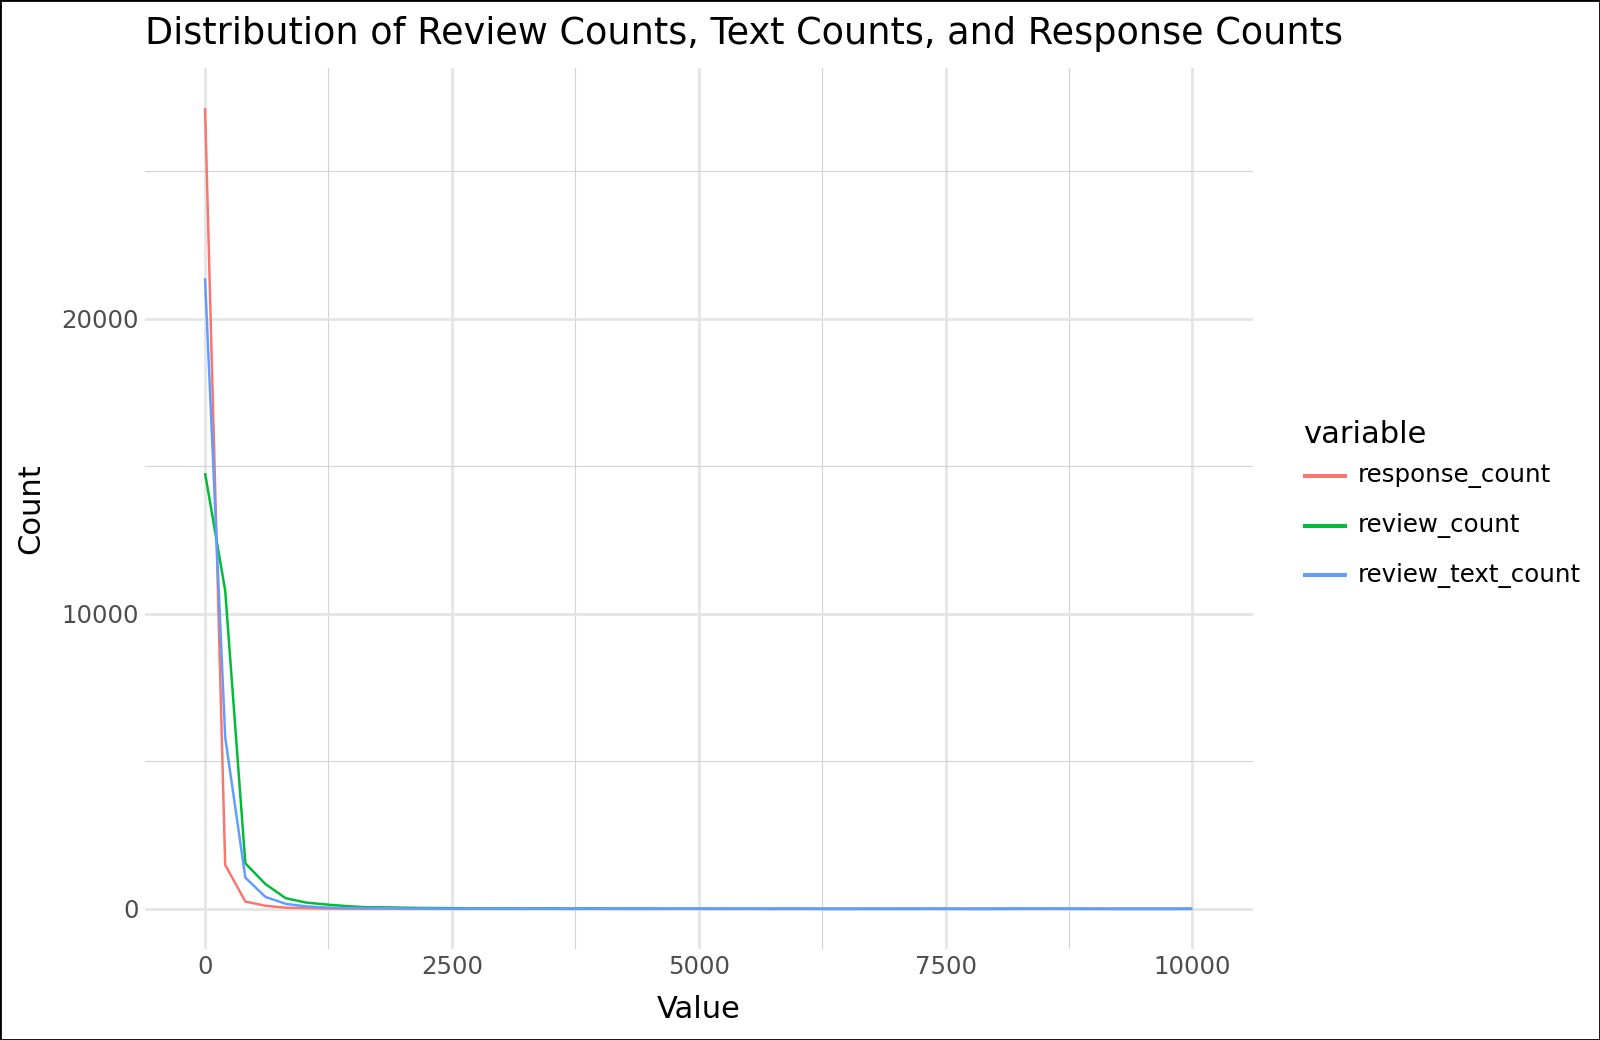

In [10]:
# Select the columns 'review_count', 'review_text_count', and 'response_count' from 'gmap_info'
# Reshape the DataFrame to a long format for easier plotting, with 'variable' and 'value' columns
gmap_info_for_visual = gmap_info[['review_count', 'review_text_count', 'response_count']].melt(var_name = 'variable', value_name = 'value')

# Create a frequency polygon plot to visualize the distribution of review counts, text counts, and response counts
(ggplot(gmap_info_for_visual, mapping = aes(x = 'value', color = 'variable')) +
    geom_freqpoly(bins = 50) +  # Plot the frequency polygons with 50 bins
    labs(
        title = 'Distribution of Review Counts, Text Counts, and Response Counts',  # Add a title to the plot
        x = 'Value',  # Label for the x-axis
        y = 'Count'   # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4)  # Style the minor grid lines
    )
)

From the chart, we can observe the following points:
- **Concentration:** All three variables are concentrated in the lower value range.
- **Similarity between `review_count` and `review_text_count`:** The distribution shapes of the green and blue lines are similar, indicating a certain correlation between the number of text reviews and the total number of reviews.
- **Sparsity of `response_count`:** The red line shows that the `response_count` data is significantly concentrated in the lower value range. The distribution pattern suggests that most businesses rarely respond to reviews. This may reflect a lack of attention to customer feedback in some industries.
- **Long-Tail Distribution:** All variables exhibit a long-tail distribution, especially `review_count`. This indicates that a small number of businesses have a large number of reviews, text reviews, and even responses. We hypothesize that these businesses may have higher ratings.

For `earliest_review_date` and `latest_review_date`, we also create an overlay histogram similar to the one above

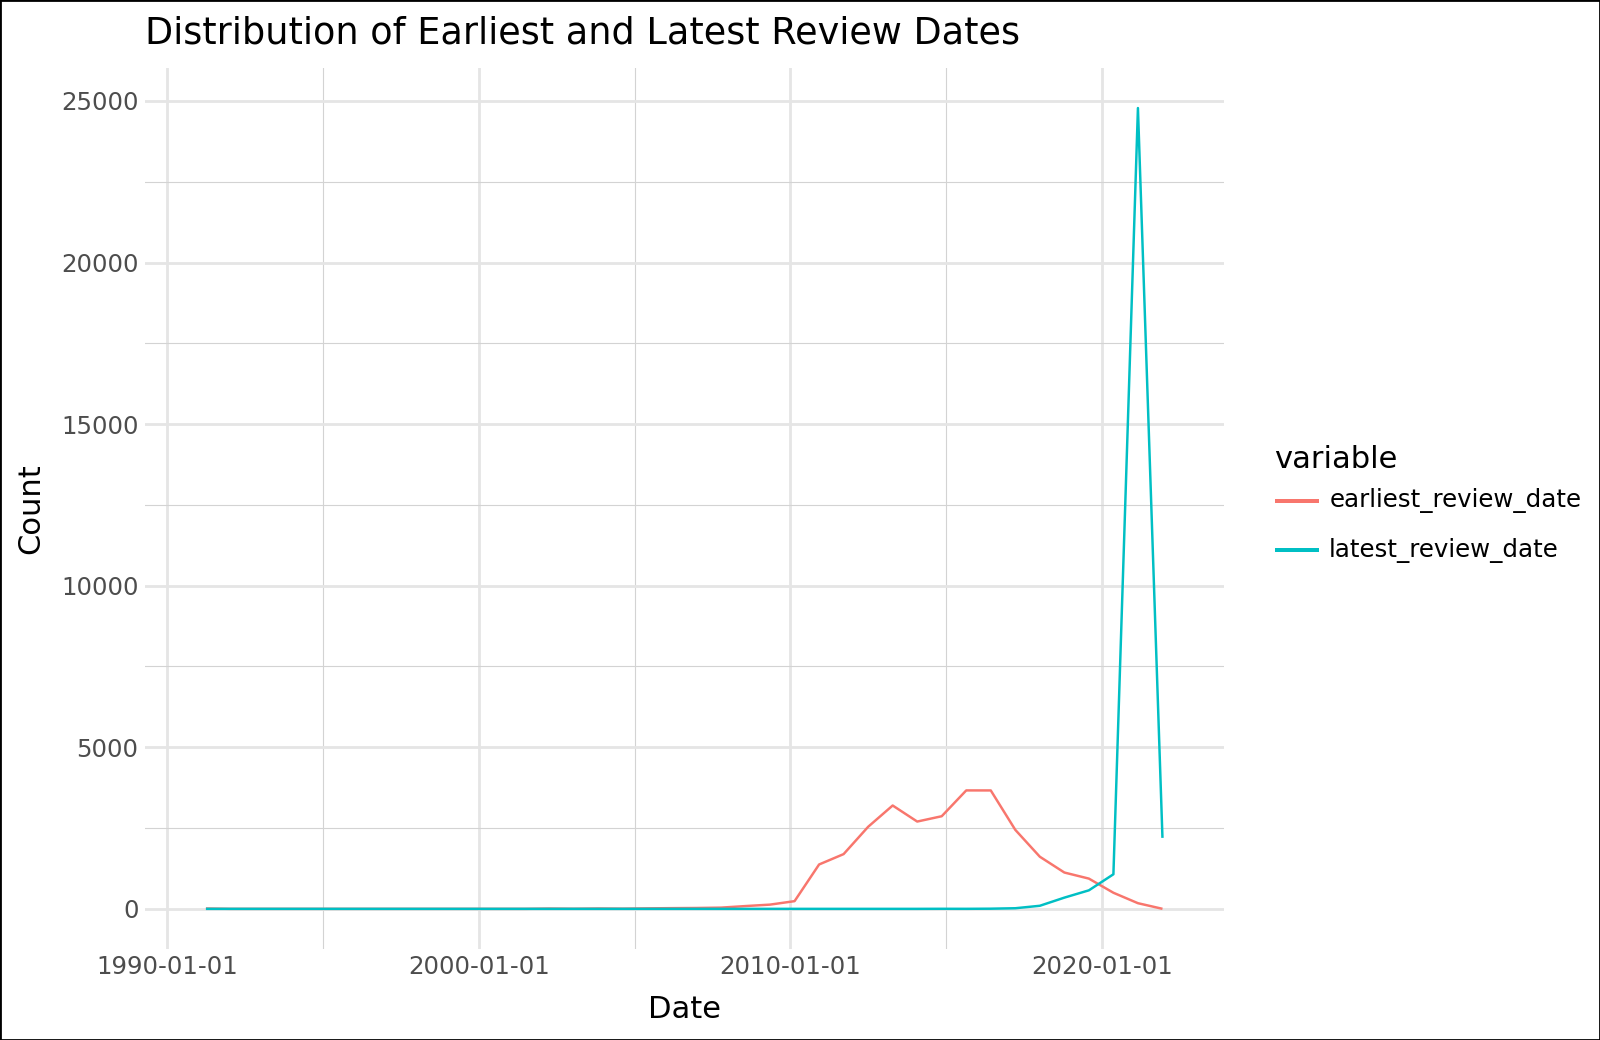

In [11]:
# Convert the datetime columns ('earliest_review_date' and 'latest_review_date') to long format
gmap_info_for_visual = gmap_info[['earliest_review_date', 'latest_review_date']].melt(var_name = 'variable', value_name = 'date')

# Plot a frequency polygon for the distribution of the datetime values
(ggplot(gmap_info_for_visual, mapping = aes(x = 'date', color = 'variable')) + 
    geom_freqpoly(bins = 40) +  # Plot the frequency polygons with 40 bins
    labs(
        title = 'Distribution of Earliest and Latest Review Dates',  # Add a title to the plot
        x = 'Date',  # Label for the x-axis
        y = 'Count'  # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4)  # Style the minor grid lines
    )
)

From the chart, we can observe:
- The distribution of the earliest review dates is relatively dispersed, mostly concentrated between 2010 and 2020.
- The latest review dates have increased significantly after 2020, indicating very active review activity in recent years.
- Overall, this reflects that businesses have gained more user attention in recent years, and users have increasingly used Google Maps over the past few years.
- This also indirectly suggests potential for the recommendation system within Google Maps (as seen later in the `relative_results` column of the metadata).

## 1.3 Summarising for `gmap_reviews`

In this section, we focus on the univariate analysis of the `gmap_reviews` dataset. Specifically, we examine the distribution of each column.


In [12]:
# Print the number of records in the 'gmap_info' DataFrame
print(f'The number of records: {len(gmap_info)}')

# Display the first 5 rows of the 'gmap_reviews' DataFrame
gmap_reviews.head(5)

The number of records: 29088


name  \
gmap_id                               user_id                                  
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877      Bill Taylor   
                                      103079253096551262298  alexis ceballos   
                                      103122076323828911215       Dan Kelley   
                                      117974159860031660818       Kavin Conn   
                                      100368141243486348290    Celeste Fleek   

                                                                           time  \
gmap_id                               user_id                                     
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877 2021-04-03 18:23:52   
                                      103079253096551262298 2019-07-20 22:37:02   
                                      103122076323828911215 2021-04-29 08:01:17   
                                      117974159860031660818 2021-04-19 20:33:40   
                                      100368141243486348290 2021-03-29 01:14:15   

                                                             review_rating  \
gmap_id                               user_id                                
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877            5.0   
                                      103079253096551262298            5.0   
                                      103122076323828911215            5.0   
                                      117974159860031660818            5.0   
                                      100368141243486348290            5.0   

                                                                                                   review_text  \
gmap_id                               user_id                                                                    
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877  We met with friends at this restaurant for din...   
                                      103079253096551262298  Best place on earth !!! Good staff cool little...   
                                      103122076323828911215          Awesome bar. Great vibe. Fantastic folks.   
                                      117974159860031660818  Fun friendly good service new look a family of...   
                                      100368141243486348290  Couldn't find a better bartender than Connie s...   

                                                            review_text_pre_translated  \
gmap_id                               user_id                                            
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877                       None   
                                      103079253096551262298                       None   
                                      103122076323828911215                       None   
                                      117974159860031660818                       None   
                                      100368141243486348290                       None   

                                                                                                          pics  \
gmap_id                               user_id                                                                    
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877                                               None   
                                      103079253096551262298  [{'url': ['https://lh5.googleusercontent.com/p...   
                                      103122076323828911215                                               None   
                                      117974159860031660818                                               None   
                                      100368141243486348290                                               None   

                                                            resp_text  \
gmap_id                               user_id                           
0x54d46

The following statistics show:
- **review_rating**: The `review_rating` column exhibits a strong left-skewed distribution, as its 25th percentile is 4.0.
- **n_pictures**: The vast majority of reviews have no pictures, with the 75th percentile of the `n_pictures` column being 0.
- **len_review_text**: Similarly, most reviews have either no text or very short text. There are a few reviews with exceptionally long text.
- **time**: Similar to the distribution of the `latest_review_time` column in `gmap_info`, most reviews were published in recent years.
- **if_response**: The `if_response` column is not displayed here due to its data type.

As before, we create some visualizations to better understand the data.


In [13]:
# Generate descriptive statistics for the 'gmap_reviews' DataFrame
gmap_reviews.describe()

,time,review_rating,n_pictures,len_review_text
count,5767463,5.757080e+06,5.767463e+06,5.767463e+06
mean,2019-02-22 14:17:18.714720512,4.364358e+00,8.683575e-02,1.693192e+01
min,1990-12-31 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2018-03-28 01:39:03.500000,4.000000e+00,0.000000e+00,0.000000e+00
50%,2019-04-20 07:46:36,5.000000e+00,0.000000e+00,4.000000e+00
75%,2020-03-04 00:09:03.500000,5.000000e+00,0.000000e+00,1.900000e+01
max,2021-09-08 21:36:49,5.000000e+00,5.000000e+01,1.528000e+03
std,NaN,1.145083e+00,8.921280e-01,3.630023e+01



Although `review_rating` is a numerical column, it has only five unique values. We treat it as a categorical feature and plot a bar plot alongside the `if_response` column to visualize their respective frequencies.


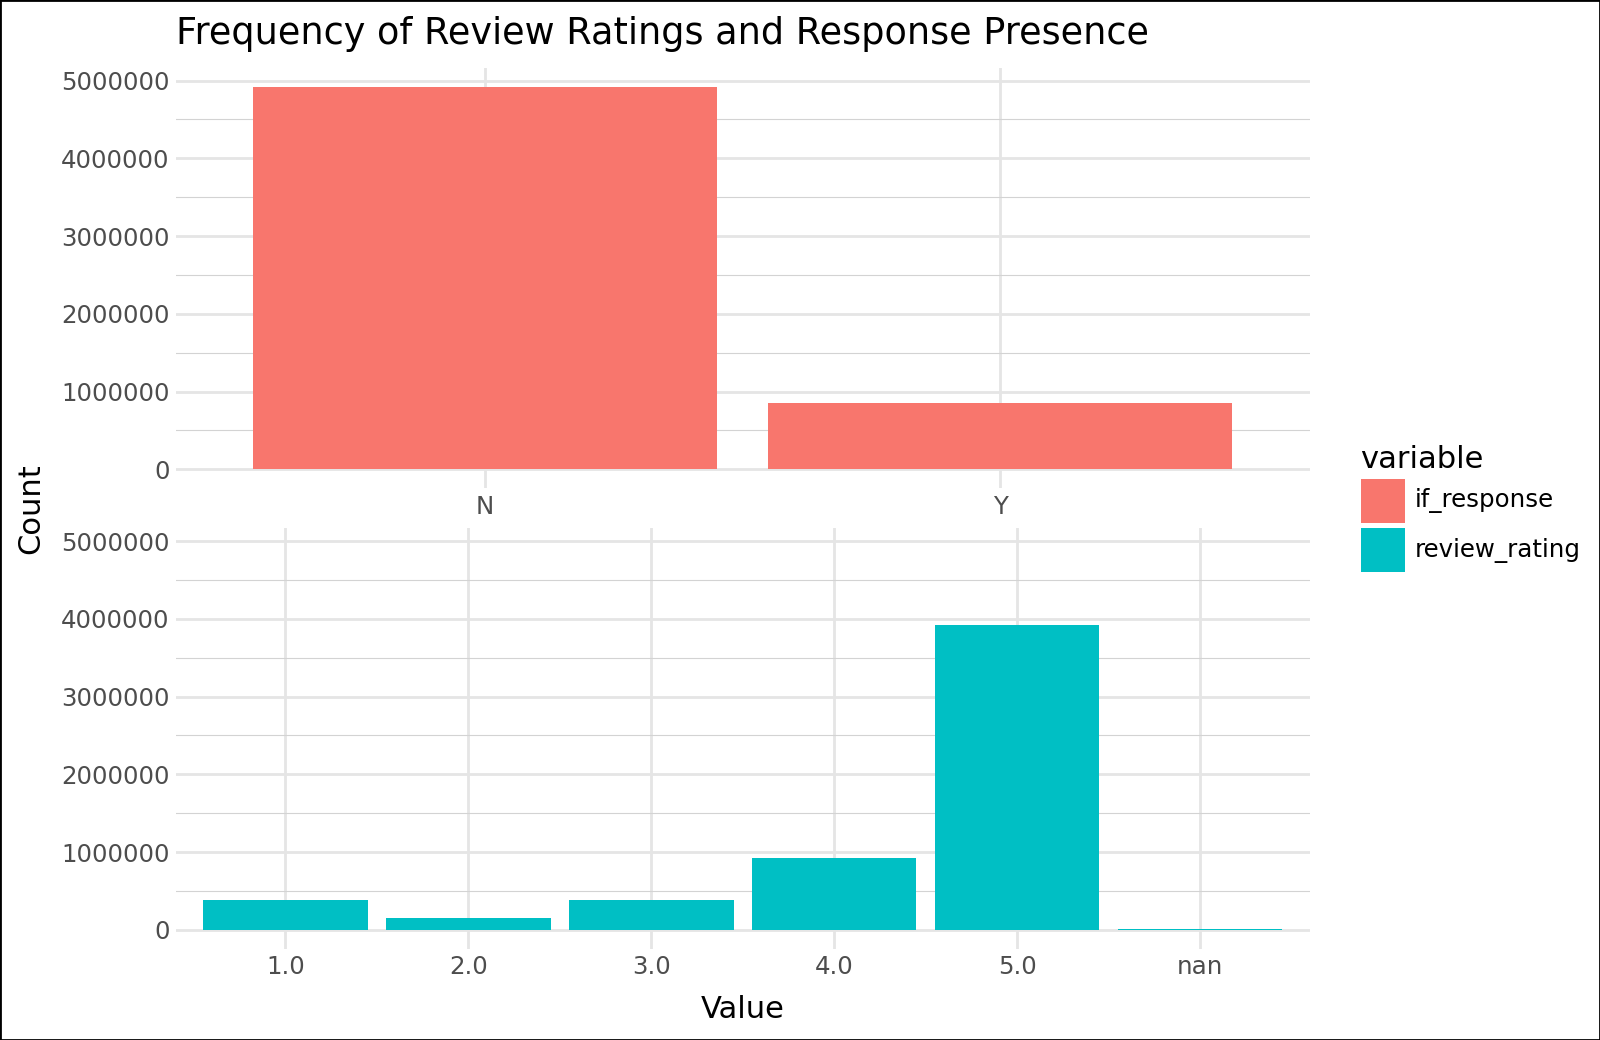

In [14]:
# Ensure all data is converted to string type for consistent plotting
gmap_reviews_for_visual = (gmap_reviews[['review_rating', 'if_response']]
    .astype(str)  # Convert the selected columns to string type
    .melt(var_name = 'variable', value_name = 'value')  # Reshape the DataFrame to long format
)

# Plotting the frequency of review ratings and response presence
(ggplot(gmap_reviews_for_visual, mapping = aes(x = 'value')) +
    geom_bar(mapping = aes(fill = 'variable')) +  # Create a bar plot, with bars colored by 'variable'
    labs(
        title = 'Frequency of Review Ratings and Response Presence',  # Add a title to the plot
        x = 'Value',  # Label for the x-axis
        y = 'Count'   # Label for the y-axis
    ) +
    facet_wrap('~ variable', ncol = 1, scales = 'free_x') +  # Create separate subplots for each variable, with independent x-axis scales
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Style the minor grid lines
        strip_text = element_blank()  # Hide the subplot labels (facet strip texts)
    )
)

From the chart, we can observe:
- Most reviews did not receive a response (N), as indicated by the taller bar on the left. The number of reviews without a response is much greater than those with a response (Y).
- Review ratings are concentrated in the higher range (4 and 5 stars), with 5-star ratings being the most frequent, close to 20,000. Low ratings (1 to 3 stars) are relatively fewer.

We plot histograms for the `n_pictures`, `len_review_text`, and `time` columns separately to examine their distributions.

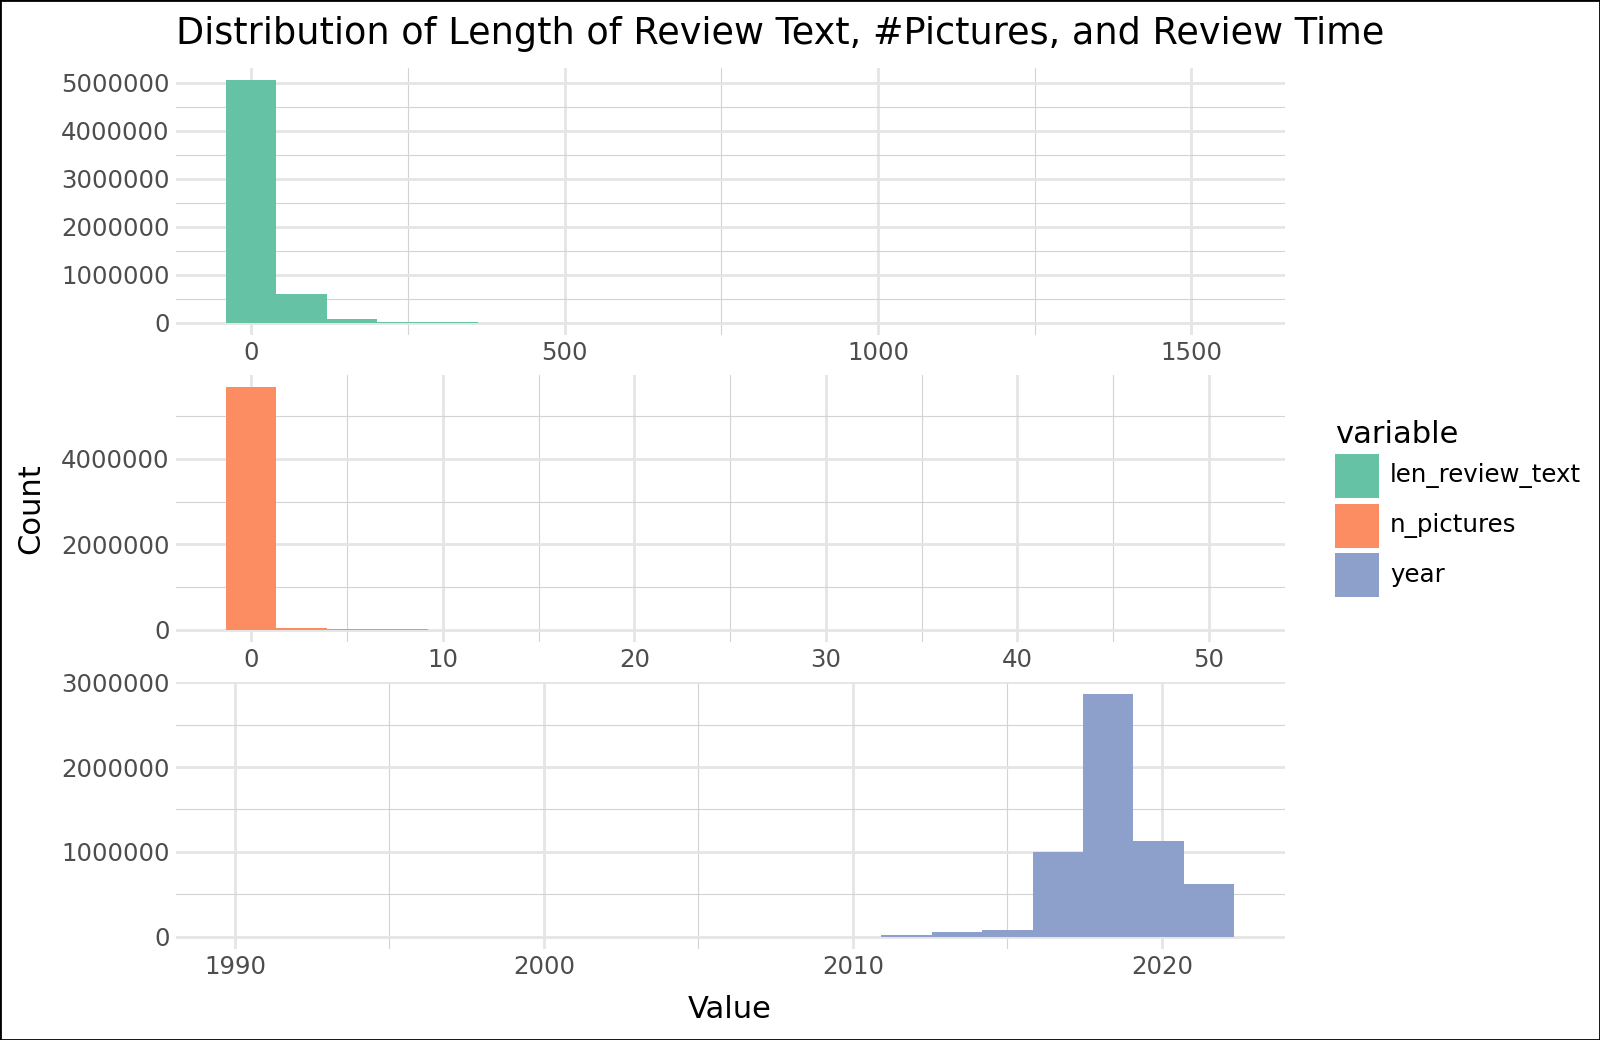

In [15]:
# Create a new DataFrame from 'gmap_reviews' and convert the 'time' column to the year, without modifying the original dataset
gmap_reviews_for_visual = gmap_reviews[['n_pictures', 'len_review_text', 'time']].copy()
gmap_reviews_for_visual['year'] = gmap_reviews_for_visual['time'].dt.year

# Reshape the DataFrame to long format, using the newly created 'year' column and keeping the original 'time' column unchanged
gmap_reviews_for_visual = (gmap_reviews_for_visual[['n_pictures', 'len_review_text', 'year']]
    .melt(var_name = 'variable', value_name = 'value')
)

# Plotting the histogram for the distribution of review text length, number of pictures, and review time (by year)
(ggplot(gmap_reviews_for_visual, mapping = aes(x = 'value')) +
    geom_histogram(mapping = aes(fill = 'variable'), bins = 20) +  # Create a histogram with 20 bins, colored by variable
    labs(
        title = 'Distribution of Length of Review Text, #Pictures, and Review Time',  # Add a title to the plot
        x = 'Value',  # Label for the x-axis
        y = 'Count'   # Label for the y-axis
    ) +
    facet_wrap('~ variable', scales = 'free', ncol = 1) +  # Create separate subplots for each variable, with independent scales
    scale_fill_brewer(palette = 'Set2', type = 'qual') +  # Use a qualitative color palette for fill colors
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Style the minor grid lines
        strip_text = element_blank()  # Hide the subplot labels (facet strip texts)
    )
)

From the charts, we can see:
- **len_review_text**: The majority of review texts are short, concentrated between 0 and 100 words. The number of reviews decreases rapidly as text length increases. The distribution is right-skewed, with only a small number of reviews having long texts (over 200 words).
- **n_pictures**: Most reviews do not contain any pictures, which is evident from the tall bar at 0. Only a small number of reviews include a few pictures, with almost none containing more than 5 pictures.
- **time**: Here, we extracted the year from the `time` column. The number of reviews increases gradually over the years, with a significant rise after 2015, peaking between 2018 and 2020. This pattern closely mirrors the distribution of `lastest_review_time` because it can be considered as a mixed distribution of `earliest_review_time` and `lastest_review_time`.

## 1.4 Preliminary Trends and Patterns

In [16]:
# Display the first 5 rows of the 'gmap_info' DataFrame
gmap_info.head(5)

,review_count,review_text_count,response_count,earliest_review_date,latest_review_date
gmap_id,,,,,
0x14e01eb3852caf59:0x381f9a958435f502,68,29,0,2015-12-30 01:30:31,2021-05-17 21:05:27
0x14e036ddeb07f8e7:0x52211982ce605a81,68,27,0,2015-03-09 02:11:28,2021-03-31 09:12:35
0x14e177e66ec01f79:0x11d08fd54eebed7e,128,113,43,2016-05-26 11:33:41,2021-06-17 17:12:46
0x14e19dbfedc0c44b:0xe507b98095e6f001,102,72,1,2015-09-12 06:57:01,2021-06-06 05:42:53
0x14e19f36dc395749:0xd860865200fa942d,108,64,1,2015-04-21 15:28:40,2021-05-28 17:53:50


In [17]:
# Display the first 5 rows of the 'gmap_reviews' DataFrame
gmap_reviews.head(5)

name  \
gmap_id                               user_id                                  
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877      Bill Taylor   
                                      103079253096551262298  alexis ceballos   
                                      103122076323828911215       Dan Kelley   
                                      117974159860031660818       Kavin Conn   
                                      100368141243486348290    Celeste Fleek   

                                                                           time  \
gmap_id                               user_id                                     
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877 2021-04-03 18:23:52   
                                      103079253096551262298 2019-07-20 22:37:02   
                                      103122076323828911215 2021-04-29 08:01:17   
                                      117974159860031660818 2021-04-19 20:33:40   
                                      100368141243486348290 2021-03-29 01:14:15   

                                                             review_rating  \
gmap_id                               user_id                                
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877            5.0   
                                      103079253096551262298            5.0   
                                      103122076323828911215            5.0   
                                      117974159860031660818            5.0   
                                      100368141243486348290            5.0   

                                                                                                   review_text  \
gmap_id                               user_id                                                                    
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877  We met with friends at this restaurant for din...   
                                      103079253096551262298  Best place on earth !!! Good staff cool little...   
                                      103122076323828911215          Awesome bar. Great vibe. Fantastic folks.   
                                      117974159860031660818  Fun friendly good service new look a family of...   
                                      100368141243486348290  Couldn't find a better bartender than Connie s...   

                                                            review_text_pre_translated  \
gmap_id                               user_id                                            
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877                       None   
                                      103079253096551262298                       None   
                                      103122076323828911215                       None   
                                      117974159860031660818                       None   
                                      100368141243486348290                       None   

                                                                                                          pics  \
gmap_id                               user_id                                                                    
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877                                               None   
                                      103079253096551262298  [{'url': ['https://lh5.googleusercontent.com/p...   
                                      103122076323828911215                                               None   
                                      117974159860031660818                                               None   
                                      100368141243486348290                                               None   

                                                            resp_text  \
gmap_id                               user_id                           
0x54d46

We are particularly interested in exploring the relationship between the `review_rating` column and other features. Intuitively, we believe it should be related to the number of pictures and the word count of the reviews. To investigate this, we plotted the following two box plots.

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_boxplot : Removed 10372 rows containing non-finite values.


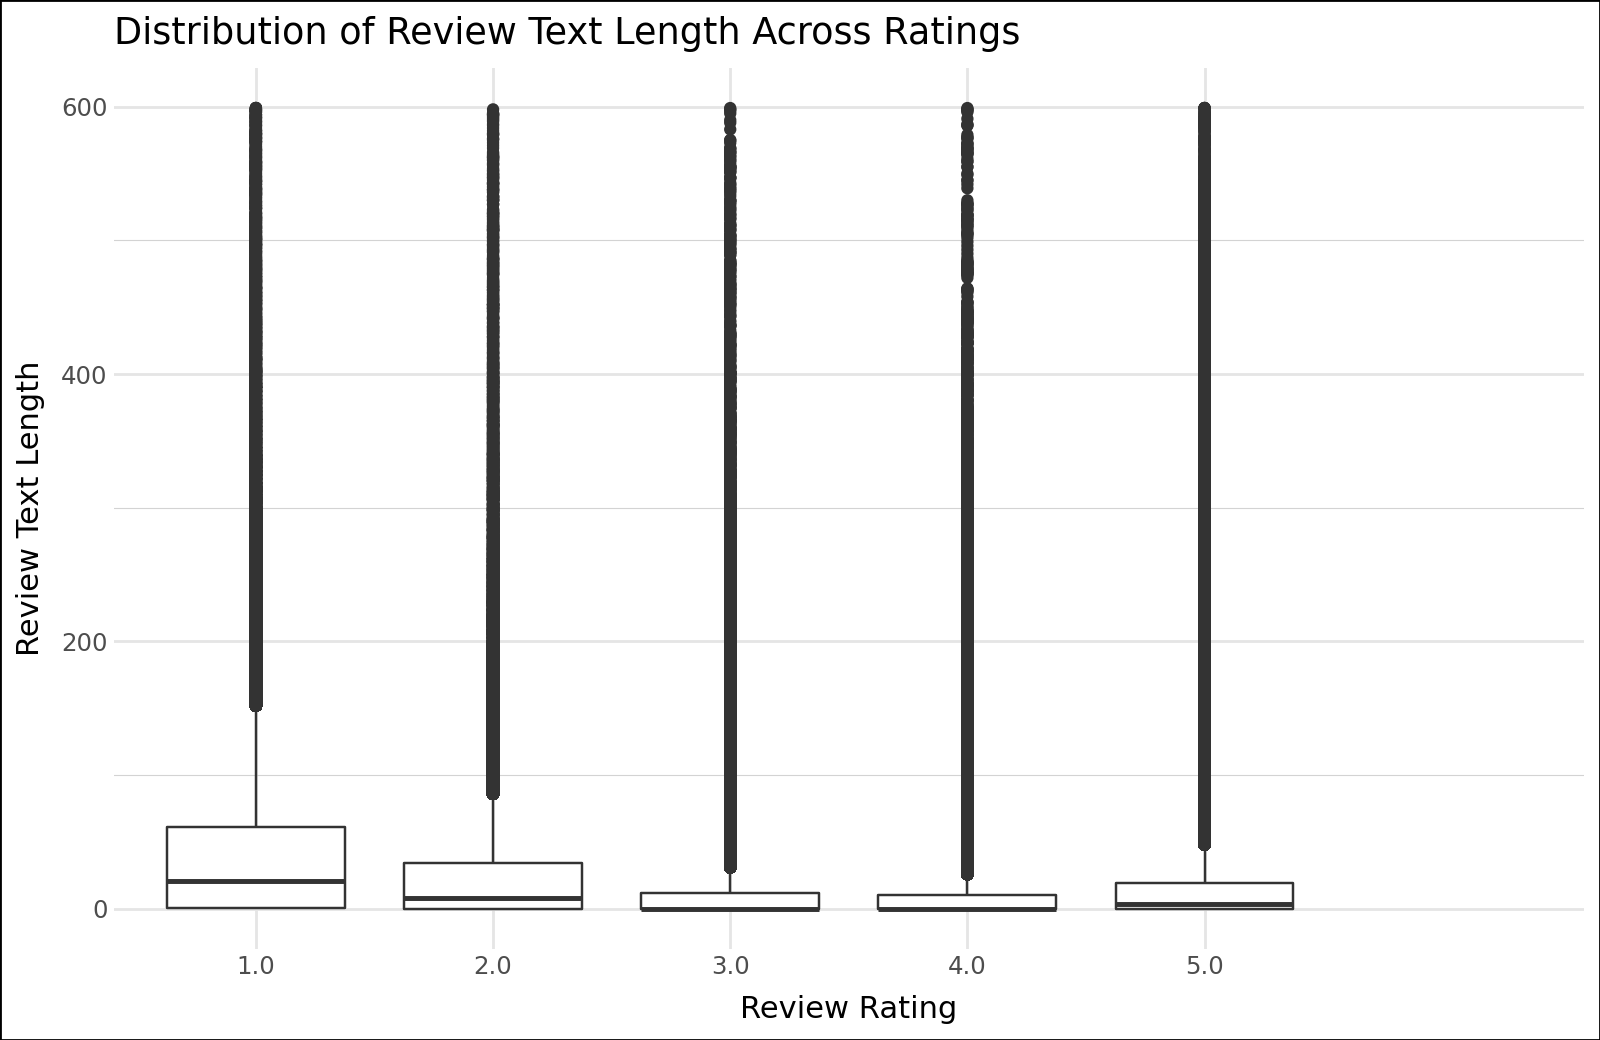

In [18]:
# Filter the 'gmap_reviews' DataFrame to include only reviews with a text length of less than 600 words
gmap_reviews_for_visual = gmap_reviews[gmap_reviews['len_review_text'] < 600]

# Create a boxplot to visualize the distribution of review text length across different ratings
(ggplot(gmap_reviews_for_visual, mapping = aes(x = 'factor(review_rating)', y = 'len_review_text')) +
    geom_boxplot() +  # Add a boxplot layer to the plot
    labs(
        title = 'Distribution of Review Text Length Across Ratings',  # Add a title to the plot
        x = 'Review Rating',  # Label for the x-axis
        y = 'Review Text Length'  # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Style the minor grid lines
    )
)

From the first box plot above, we can observe:
- Regardless of the rating, the review text length is generally concentrated in a short range.
- Nevertheless, it can be noted that reviews with a rating of 1.0 tend to have relatively longer review texts.

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_boxplot : Removed 10383 rows containing non-finite values.


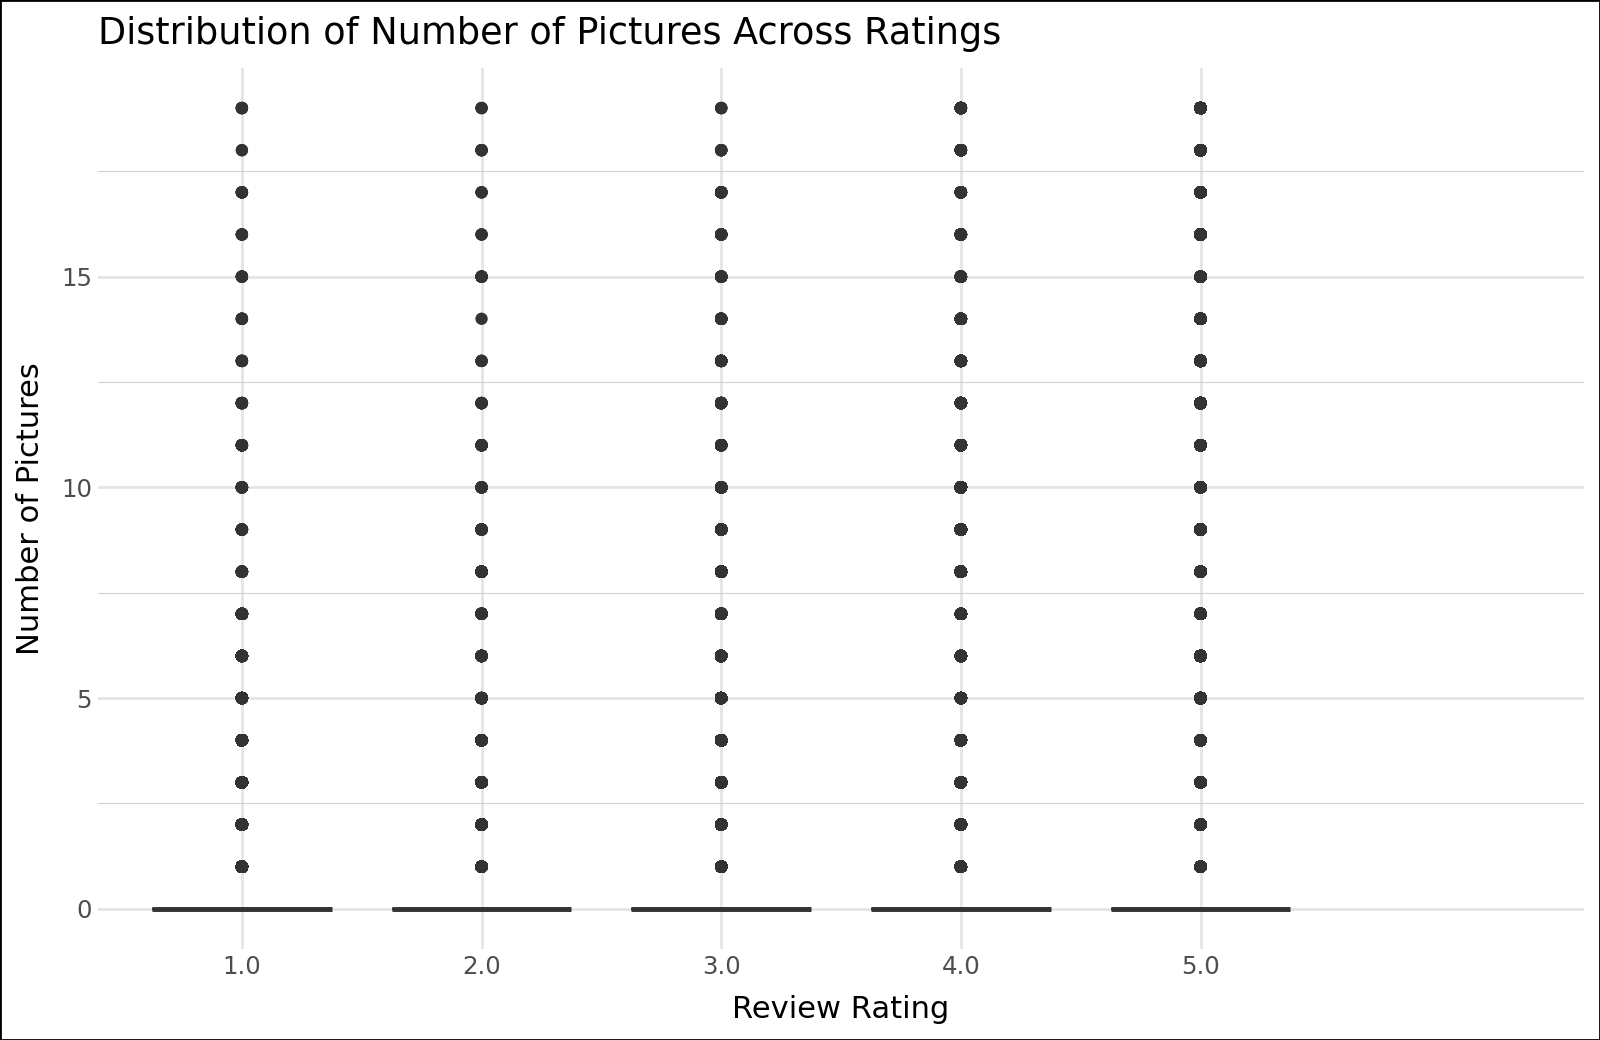

In [19]:
# Filter the 'gmap_reviews' DataFrame to include only reviews with fewer than 20 pictures
gmap_reviews_for_visual = gmap_reviews[gmap_reviews['n_pictures'] < 20]

# Create a boxplot to visualize the distribution of the number of pictures across different ratings
(ggplot(gmap_reviews_for_visual, mapping = aes(x = 'factor(review_rating)', y = 'n_pictures')) +
    geom_boxplot() +  # Add a boxplot layer to the plot
    labs(
        title = 'Distribution of Number of Pictures Across Ratings',  # Add a title to the plot
        x = 'Review Rating',  # Label for the x-axis
        y = 'Number of Pictures'  # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Style the minor grid lines
    )
)

From the second box plot above, we can see that most reviews contain very few pictures, to the extent that both Q1 and Q3 are at 0 (hence the rectangle of the box plot is not visible). This plot does not reveal any clear relationship between `review_rating` and the number of pictures.

If we consider the review text length and the number of pictures together, would the `review_rating` show any changes? Given that reviews with a rating of 5 are significantly more frequent than those with the other four ratings, we can combine ratings 1 to 4 into one category. In the scatter plot below, red and blue points represent ratings 1-4 and 5, respectively.

C:\Users\zyyin1\AppData\Local\Temp\ipykernel_90644\443351622.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


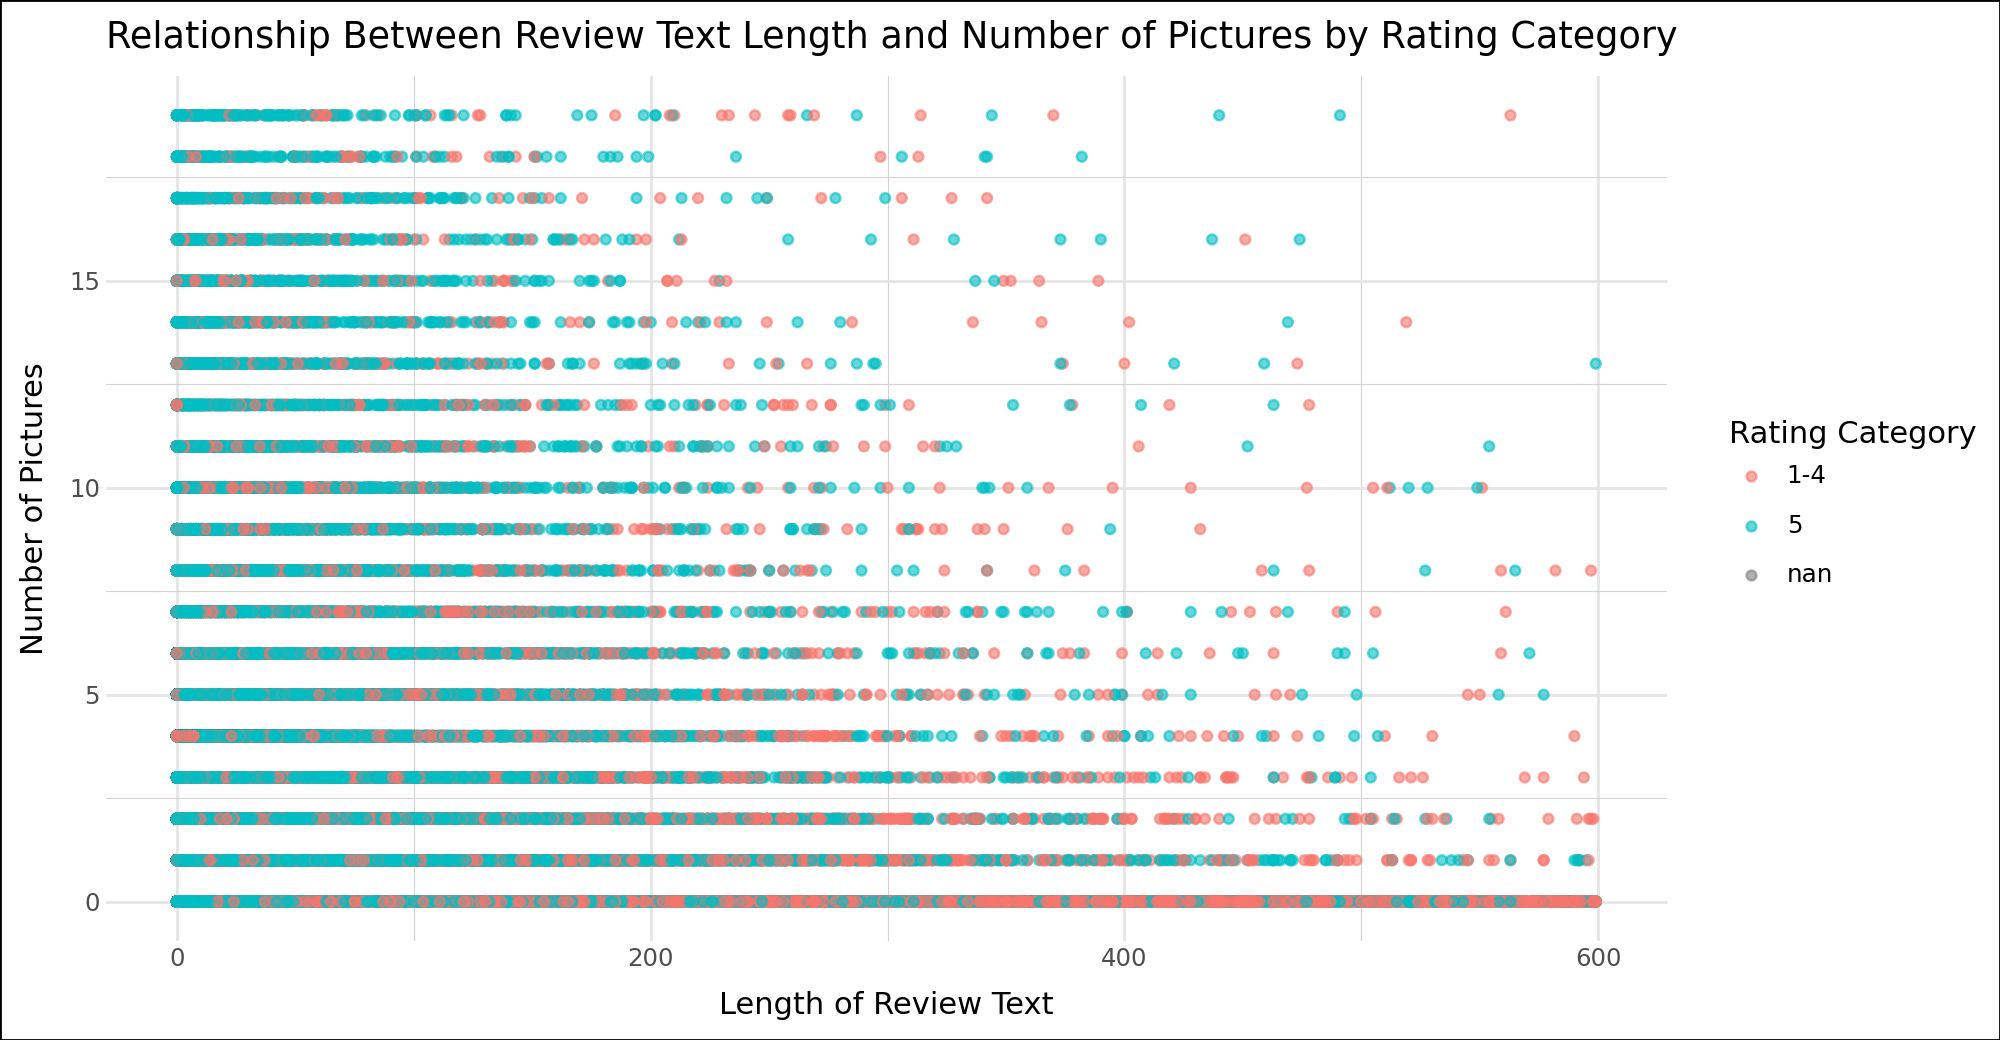

In [20]:
# Define a function to categorize the review ratings
def categorize_rating(rating):
    if rating in [1, 2, 3, 4]:
        return '1-4'  # Group ratings 1 to 4 together
    elif rating == 5:
        return '5'  # Separate category for rating 5

# Filter the 'gmap_reviews' DataFrame for reviews with fewer than 20 pictures and less than 600 words
gmap_reviews_for_visual = gmap_reviews[(gmap_reviews['n_pictures'] < 20) & (gmap_reviews['len_review_text'] < 600)]

# Apply the 'categorize_rating' function to create a new 'rating_category' column
gmap_reviews_for_visual['rating_category'] = gmap_reviews_for_visual['review_rating'].apply(categorize_rating)

# Create a scatter plot to visualize the relationship between review text length and number of pictures by rating category
(ggplot(gmap_reviews_for_visual, mapping = aes(x = 'len_review_text', y = 'n_pictures', colour = 'rating_category')) +
    geom_point(alpha = 0.6) +  # Add points to the plot with transparency for overlap
    labs(
        title = 'Relationship Between Review Text Length and Number of Pictures by Rating Category',  # Add a title to the plot
        x = 'Length of Review Text',  # Label for the x-axis
        y = 'Number of Pictures',  # Label for the y-axis
        colour = 'Rating Category'  # Label for the legend (colour)
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (10, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Style the minor grid lines
        strip_text = element_blank()  # Hide the subplot labels (facet strip texts)
    )
)

Trends observed in the above plot:

- **Number of Pictures**: Most reviews contain a low number of pictures, concentrated between 0 and 5. Reviews with a rating of 5 seem to be more concentrated within this lower range of picture numbers.

- **Text Length**: Most reviews also have shorter text lengths, concentrated between 0 and 200 words. As text length increases, there is no significant increase in the number of accompanying pictures. Reviews with a rating of 5 seem to be more concentrated in shorter texts.

These trends suggest that higher-rated reviews (those with a rating of 5) tend to contain fewer pictures and shorter text lengths. This is somewhat expected, as some businesses might engage in practices where fake accounts are used to artificially inflate their ratings.

We are also interested in whether there is a relationship between review rating and the hour of the day. We extracted the hour of the day from the `time` column.

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_sum : Removed 10383 rows containing non-finite values.


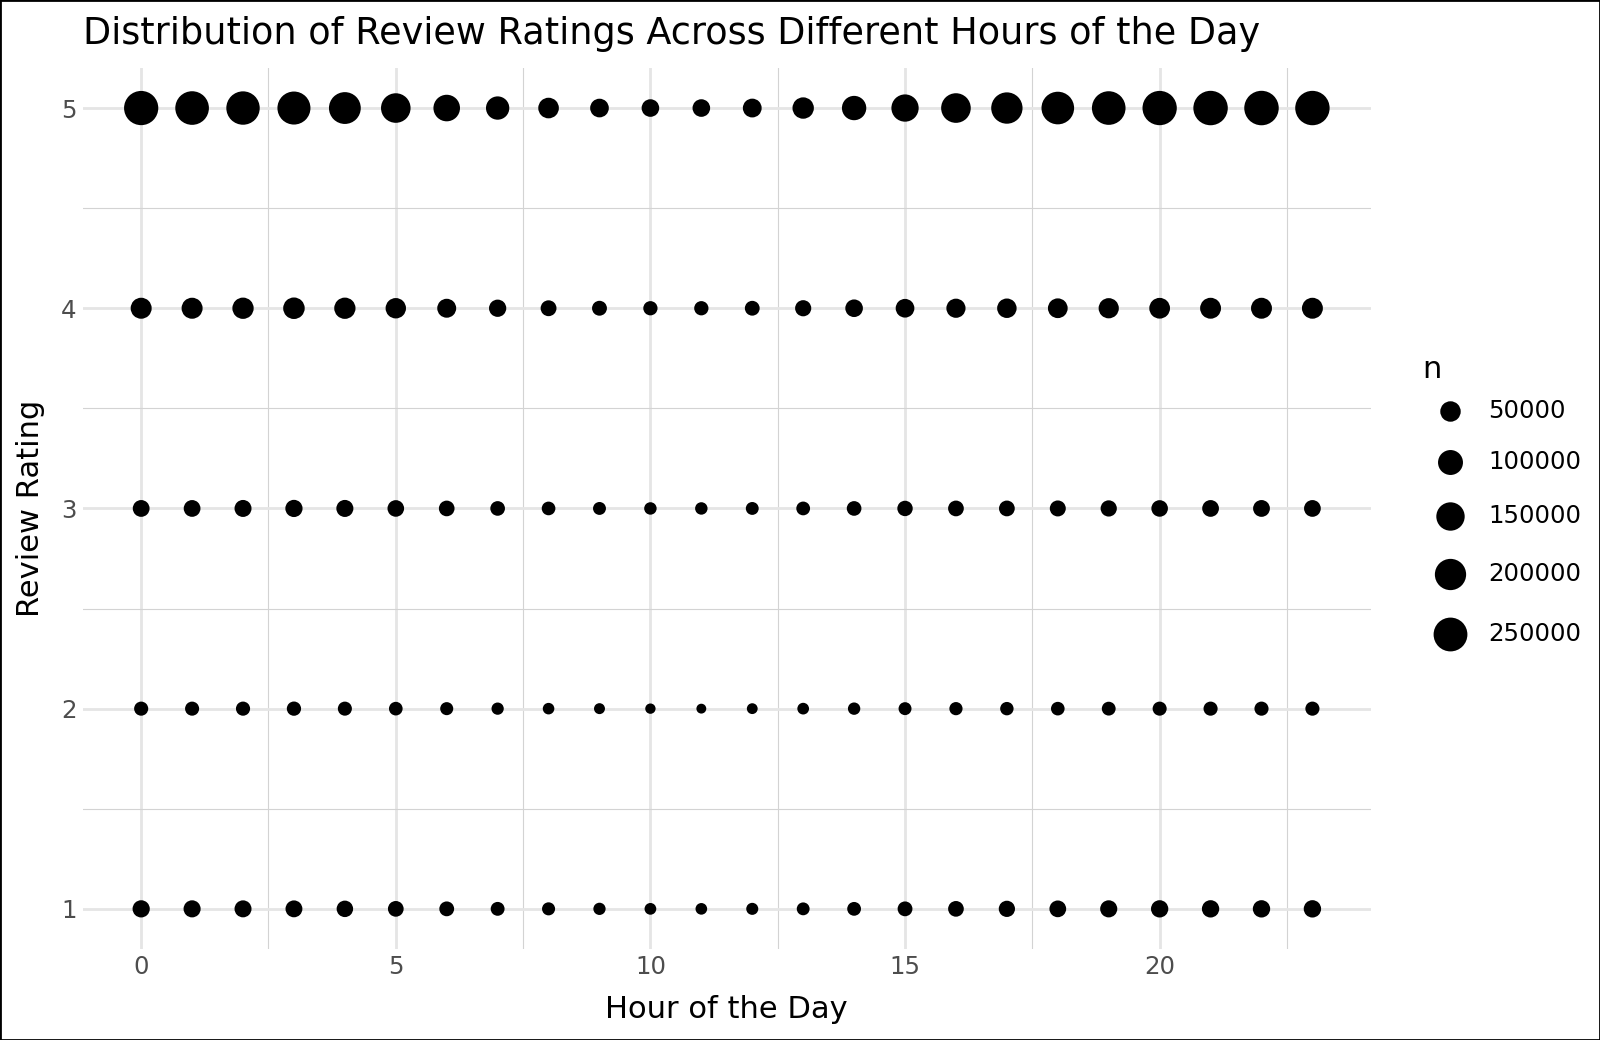

In [21]:
# Create a copy of the 'gmap_reviews' DataFrame for visualization purposes
gmap_reviews_for_visual = gmap_reviews.copy()

# Extract the hour from the 'time' column and create a new 'hour' column
gmap_reviews_for_visual['hour'] = gmap_reviews_for_visual['time'].dt.hour 

# Create a plot to visualize the distribution of review ratings across different hours of the day
(ggplot(gmap_reviews_for_visual, mapping = aes(x = 'hour', y = 'review_rating')) +
    geom_count() +  # Add a geom_count layer to show the frequency of each combination of hour and review rating
    labs(
        title = 'Distribution of Review Ratings Across Different Hours of the Day',  # Add a title to the plot
        x = 'Hour of the Day',  # Label for the x-axis
        y = 'Review Rating'  # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4)  # Style the minor grid lines
    )
)

In the above chart, the size of the dots represents the number of reviews given a specific rating at a particular hour of the day. The larger the dot, the higher the number of reviews. From the chart, we can observe:

- Low ratings of 1-3 are distributed throughout the day, with slightly more reviews at certain hours, but overall, there is no clear concentration trend.

- Certain hours, such as 1 AM and 9 PM, show a significantly higher number of reviews than other times, indicating that users are more active during these periods.

Overall, while we cannot draw a strong correlation between review rating and the hour of the day from this chart, we do observe significant differences in the number of reviews given at different hours of the day. The following bar plot was created to confirm our findings:


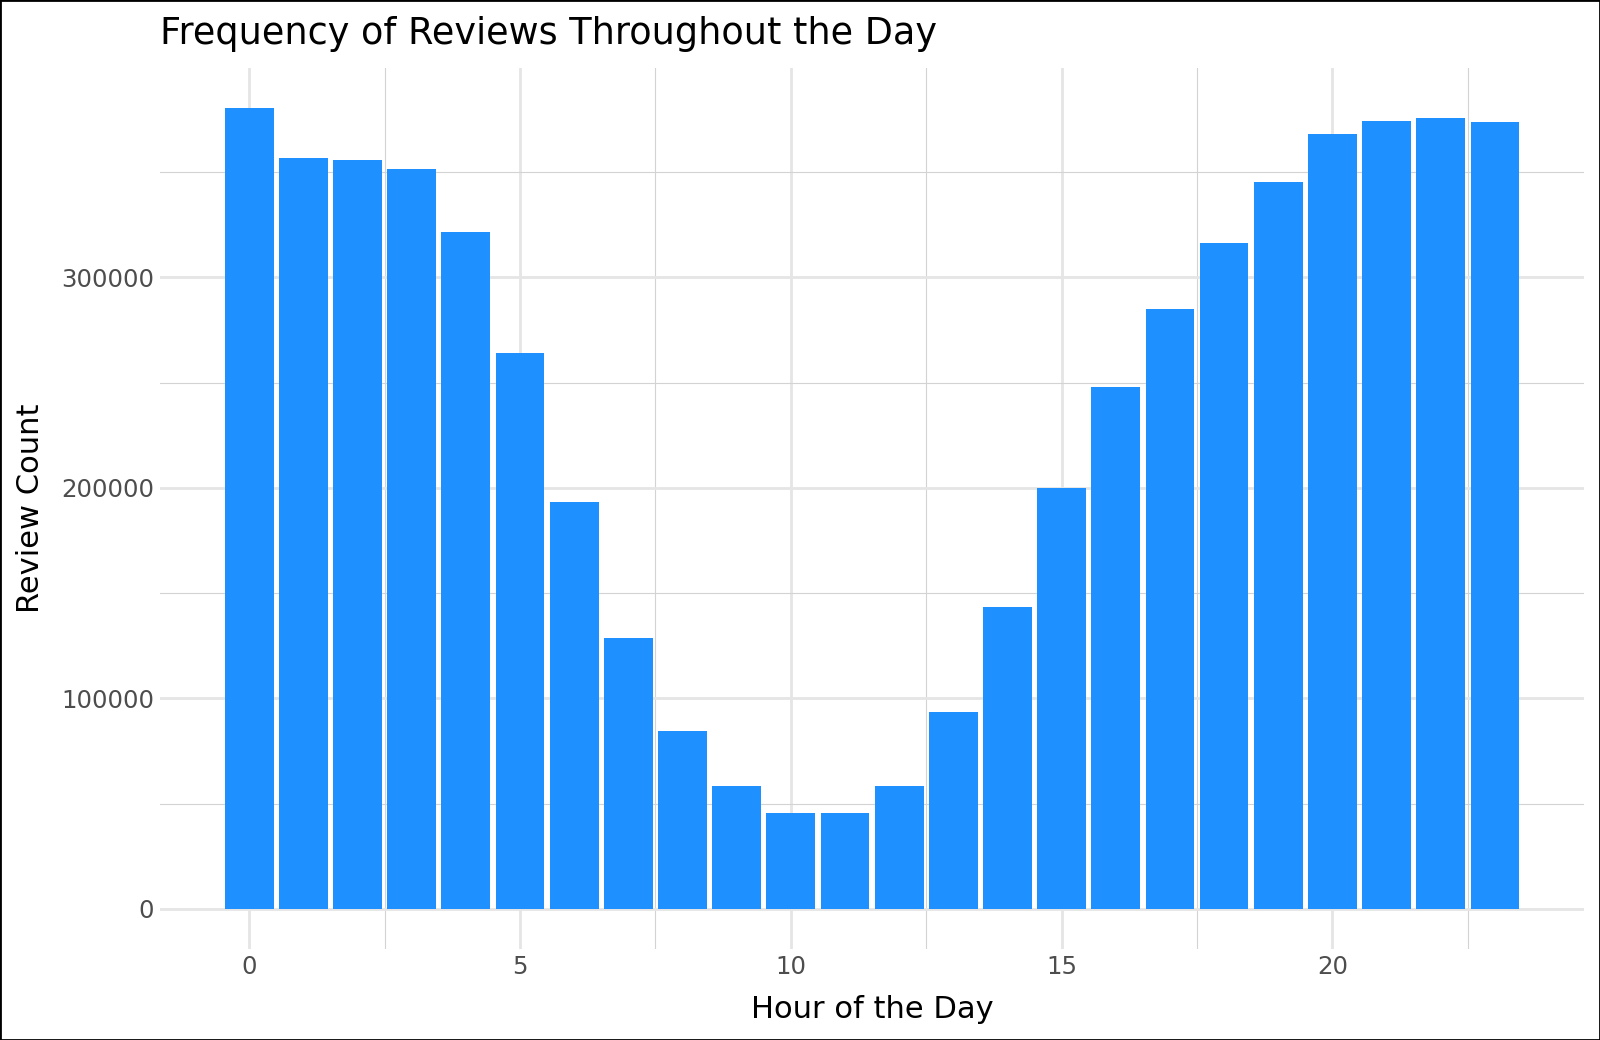

In [22]:
# Create a bar plot to visualize the frequency of reviews throughout the day
(ggplot(gmap_reviews_for_visual, mapping = aes(x = 'hour')) +
    geom_bar(fill = 'dodgerblue') +  # Create a bar plot with bars filled in 'dodgerblue' color
    labs(
        title = 'Frequency of Reviews Throughout the Day',  # Add a title to the plot
        x = 'Hour of the Day',  # Label for the x-axis
        y = 'Review Count'  # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4)  # Style the minor grid lines
    )
)

From the above bar plot, we can observe:

- **Midnight Peak:** Between 12 AM and 5 AM, there is a increase in the number of reviews. This might be because many users tend to review their experiences at the end of the day.

- **Morning and Noon Low:** From 6 AM to 12 PM, the number of reviews sharply decreases. This time period is typically when people are starting their day, busy with work or other daily activities, so the number of reviews is relatively low.

- **Afternoon to Evening Recovery:** After 3 PM, the number of reviews starts to increase, peaking again around 8 PM. This trend reflects users spending time reviewing their experiences after finishing their day’s work.

Overall, users tend to leave reviews outside of work hours, which aligns with typical daily routines.

<div class="alert alert-block alert-success">

# Step 2: Understand the Metadata <a id='optimized_loading'></a>

</div>

## 2.1 Metadata Overview

Metadata feature description：

* name - name of the business

* address - address of the business

* gmap_id - ID of the business

* description - description of the business

* latitude - latitude of the business

* longitude - longitude of the business

* category - category of the business

* avg_rating - average rating of the business

* num_of_reviews - number of reviews

* price - price of the business

* hours - open hours

* MISC - MISC information

* state - the current status of the business (e.g., permanently closed)

* relative_results - relative businesses recommended by Google

* url - URL of the business

In [23]:
# Print the number of records in the 'metadata' DataFrame
print(f'The number of records: {len(metadata)}')

# Display the first 5 rows of the 'metadata' DataFrame
metadata.head(5)

The number of records: 515961


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,None,34.018891,-118.215290,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
1,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,None,34.058092,-118.292130,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
2,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,None,34.023669,-118.232930,[Fabric store],3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
3,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,None,34.036694,-118.249421,[Fabric store],4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...
4,Matrix International Textiles,"Matrix International Textiles, 1363 S Bonnie B...",0x80c2cf163db6bc89:0x219484e2edbcfa41,None,34.015505,-118.181839,[Fabric store],3.5,6,None,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...


Set gmap_id as the row index for the metadata DataFrame.

In [24]:
# Set 'gmap_id' as the row index for the 'metadata' DataFrame
metadata = metadata.set_index('gmap_id')

We find there exists duplicated rows in metadata and choose to remove them.

In [25]:
metadata.index.duplicated().sum()

2827

In [26]:
metadata = metadata[~metadata.index.duplicated(keep = 'first')]

In [27]:
metadata.index.duplicated().sum()

0

check the data types of each column in the `metadata`

In [28]:
metadata.dtypes

name                 object
address              object
description          object
latitude            float64
longitude           float64
category             object
avg_rating          float64
num_of_reviews        int64
price                object
hours                object
MISC                 object
state                object
relative_results     object
url                  object
dtype: object

Check the number of missing values in each column.

In [29]:
metadata.apply(lambda col: (col.isnull()).sum())

name                    10
address               7613
description         401388
latitude                 0
longitude                0
category              2350
avg_rating               0
num_of_reviews           0
price               403476
hours               100253
MISC                 82190
state               143014
relative_results     40119
url                      0
dtype: int64

## 2.2 Processing & Featrue Engineering

Generate a location column using longitude and latitude information.

In [30]:
# Combine the 'latitude' and 'longitude' columns into a single 'location' column as a list [latitude, longitude]
metadata['location'] = metadata.apply(lambda row: [row['latitude'], row['longitude']], axis = 1)

# Drop the original 'latitude' and 'longitude' columns since their data is now in the 'location' column
metadata = metadata.drop(['latitude', 'longitude'], axis = 1)

# Display the first 5 rows of the updated 'metadata' DataFrame
metadata.head(5)

,name,address,description,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,location
gmap_id,,,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",None,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0188913, -118.2152898]"
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",None,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0580917, -118.2921295]"
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",None,[Fabric store],3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0236689, -118.2329297]"
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",None,[Fabric store],4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0366942, -118.2494208]"
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,"Matrix International Textiles, 1363 S Bonnie B...",None,[Fabric store],3.5,6,None,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0155047, -118.1818394]"


Extract the city information from the address column and create a new city column.

In [31]:
# For each row in the 'address' column, check if the value is not None or NaN
# If valid, split the address by commas and extract the second last element as the city name
# If the address is None or has fewer than 2 elements after splitting, return "Unknown City"
metadata['city'] = metadata['address'].apply(
    lambda x: x.split(',')[-2].strip() 
        if pd.notnull(x) and len(x.split(',')) >= 2 
        else "Unknown City"
)

# Drop the original 'address' column as its data is now in the 'city' column
metadata = metadata.drop('address', axis = 1)

# Display the first 5 rows of the updated 'metadata' DataFrame
metadata.head(5)

,name,description,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url,location,city
gmap_id,,,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,None,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0188913, -118.2152898]",Los Angeles
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,None,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0580917, -118.2921295]",Los Angeles
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,None,[Fabric store],3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0236689, -118.2329297]",Los Angeles
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,None,[Fabric store],4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0366942, -118.2494208]",Los Angeles
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,None,[Fabric store],3.5,6,None,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...",https://www.google.com/maps/place//data=!4m2!3...,"[34.0155047, -118.1818394]",Commerce


Remove the columns we are not interested in.

In [32]:
# Remove the 'description' and 'url' columns from the 'metadata' DataFrame
metadata = metadata.drop(['description', 'url'], axis = 1)

# Display the first 5 rows of the updated 'metadata' DataFrame
metadata.head(5)

,name,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,location,city
gmap_id,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,[Textile exporter],4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...","[34.0188913, -118.2152898]",Los Angeles
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,[Korean restaurant],4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...","[34.0580917, -118.2921295]",Los Angeles
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,[Fabric store],3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...","[34.0236689, -118.2329297]",Los Angeles
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,[Fabric store],4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...","[34.0366942, -118.2494208]",Los Angeles
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,[Fabric store],3.5,6,None,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...","[34.0155047, -118.1818394]",Commerce


Extract the first category from the category column and create a new primary_category column.

In [33]:
# Extract the first category from the 'category' column and create a new 'primary_category' column
# If 'category' is a list, extract the first element; otherwise, set it as "Unknown Category"
metadata['primary_category'] = metadata['category'].apply(lambda x: x[0] if isinstance(x, list) else "Unknown Category")

# Drop the original 'category' column as its data is now in the 'primary_category' column
metadata = metadata.drop('category', axis = 1)

# Display the first 5 rows of the updated 'metadata' DataFrame
metadata.head(5)

,name,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,location,city,primary_category
gmap_id,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,4.5,6,None,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...","[34.0188913, -118.2152898]",Los Angeles,Textile exporter
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,4.4,18,None,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...","[34.0580917, -118.2921295]",Los Angeles,Korean restaurant
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,3.3,6,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...","[34.0236689, -118.2329297]",Los Angeles,Fabric store
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,4.3,7,None,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...","[34.0366942, -118.2494208]",Los Angeles,Fabric store
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,3.5,6,None,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...","[34.0155047, -118.1818394]",Commerce,Fabric store


Check the unique values in the price column.

In [34]:
print(metadata['price'].unique())

[None '$' '$$' '$$$' '$$$$' '₩' '₩₩' '₩₩₩' '₩₩₩₩']


Extract information from the price column to create a price_level column.

In [35]:
# Define a mapping to convert price symbols into price levels
price_mapping = {
    '$': 'Low',
    '$$': 'Medium',
    '$$$': 'High',
    '$$$$': 'Very High',
    '₩': 'Low',
    '₩₩': 'Medium',
    '₩₩₩': 'High',
    '₩₩₩₩': 'Very High',
    None: 'Unknown Price Level',  # Handle None values and NaN values
}

# Apply the mapping to the 'price' column to create the 'price_level' column
metadata['price_level'] = metadata['price'].map(price_mapping)

# Drop the original 'price' column as its data is now in 'price_level'
metadata = metadata.drop('price', axis = 1)

# Print the count of each unique value in the 'price_level' column
print(metadata['price_level'].value_counts())

# Display the first 5 rows of the updated 'metadata' DataFrame
metadata.head(5)

price_level
Unknown Price Level    403476
Low                     55255
Medium                  50298
High                     3654
Very High                 451
Name: count, dtype: int64


,name,avg_rating,num_of_reviews,hours,MISC,state,relative_results,location,city,primary_category,price_level
gmap_id,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,4.5,6,None,None,Open now,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...","[34.0188913, -118.2152898]",Los Angeles,Textile exporter,Unknown Price Level
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,4.4,18,"[[Thursday, 6:30AM–6PM], [Friday, 6:30AM–6PM],...","{'Service options': ['Takeout', 'Dine-in', 'De...",Open ⋅ Closes 6PM,"[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...","[34.0580917, -118.2921295]",Los Angeles,Korean restaurant,Unknown Price Level
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,3.3,6,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Pa...",Open ⋅ Closes 5PM,"[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...","[34.0236689, -118.2329297]",Los Angeles,Fabric store,Unknown Price Level
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,4.3,7,"[[Thursday, 9AM–5PM], [Friday, 9AM–5PM], [Satu...",{'Service options': ['In-store pickup']},Open ⋅ Closes 5PM,"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...","[34.0366942, -118.2494208]",Los Angeles,Fabric store,Unknown Price Level
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,3.5,6,"[[Thursday, 8:30AM–5:30PM], [Friday, 8:30AM–5:...",{'Accessibility': ['Wheelchair accessible entr...,Open ⋅ Closes 5:30PM,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...","[34.0155047, -118.1818394]",Commerce,Fabric store,Unknown Price Level


We extracted the number of operating days per week into the `operating_days` column and the average daily operating hours into the `average_daily_hours` column from the hours column. There are many missing values in the hours column, which results in an `operating_days` value of 0. We consider such businesses as permanently closed.

In [36]:
metadata['operating_days'] = metadata['hours'].apply(
    lambda x: len([day for day in x if "Closed" not in day[1]]) if isinstance(x, list) else 0
)

In [37]:
from datetime import datetime, timedelta

# Function to parse time strings into datetime objects
def parse_time(time_str):
    time_str = time_str.strip()
    
    # Handle the case where the business is open 24 hours
    if "Open 24 hours" in time_str:
        return "24_hours"
    
    # Handle cases where the time is given as just an hour, e.g., "3"
    if time_str.isdigit() and len(time_str) <= 2:
        return datetime.strptime(time_str + "PM", "%I%p")
    
    # Different time formats to try parsing
    time_formats = ["%I:%M%p", "%I%p", "%H:%M", "%I:%M"]
    
    for fmt in time_formats:
        try:
            return datetime.strptime(time_str, fmt)
        except ValueError:
            continue

# Function to calculate average daily operating hours
def calculate_daily_hours(hours):
    total_hours = 0
    operating_days = 0
    
    for day, time_range in hours:
        if "Closed" not in time_range:
            if "Open 24 hours" in time_range:
                hours_open = 24
            else:
                # Parse open and close times
                open_time, close_time = [parse_time(t) for t in time_range.split('–')]
                if open_time == "24_hours":
                    hours_open = 24
                else:
                    hours_open = (close_time - open_time).seconds / 3600
            total_hours += hours_open
            operating_days += 1
    
    # Calculate average daily hours, return 0 if no operating days
    return total_hours / operating_days if operating_days > 0 else 0

# Apply the calculate_daily_hours function to each row in the 'hours' column
metadata['average_daily_hours'] = metadata['hours'].apply(
    lambda x: calculate_daily_hours(x) if isinstance(x, list) else 0
)

Remove the hours column, which has already been used. Also, remove the state column, as we consider it to have no value for feature engineering.

In [38]:
metadata = metadata.drop(['hours', 'state'], axis = 1)
metadata.head(5)

,name,avg_rating,num_of_reviews,MISC,relative_results,location,city,primary_category,price_level,operating_days,average_daily_hours
gmap_id,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,4.5,6,None,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...","[34.0188913, -118.2152898]",Los Angeles,Textile exporter,Unknown Price Level,0,0.000000
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,4.4,18,"{'Service options': ['Takeout', 'Dine-in', 'De...","[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...","[34.0580917, -118.2921295]",Los Angeles,Korean restaurant,Unknown Price Level,6,10.416667
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,3.3,6,"{'Service options': ['In-store shopping'], 'Pa...","[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...","[34.0236689, -118.2329297]",Los Angeles,Fabric store,Unknown Price Level,5,8.000000
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,4.3,7,{'Service options': ['In-store pickup']},"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...","[34.0366942, -118.2494208]",Los Angeles,Fabric store,Unknown Price Level,5,8.000000
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,3.5,6,{'Accessibility': ['Wheelchair accessible entr...,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...","[34.0155047, -118.1818394]",Commerce,Fabric store,Unknown Price Level,5,9.000000


The MISC column contains various service types. Under each service type, there are further detailed sub-services. As shown below:

In [39]:
# Initialize an empty set to store all unique keys
all_keys = set()

# Iterate through the 'MISC' column and extract keys from each dictionary
for misc in metadata['MISC'].dropna():
    for key in misc.keys():
        all_keys.add(key)

# Print all the unique keys found
print(all_keys)

{'Service options', 'Atmosphere', 'Highlights', 'Lodging options', 'Activities', 'Payments', 'Amenities', 'Dining options', 'Health and safety', 'Getting here', 'Planning', 'From the business', 'Offerings', 'Recycling', 'Accessibility', 'Crowd', 'Popular for', 'Health & safety'}


We consider the two most important service types to be 'Service options' and 'Accessibility'. We count their sub-services separately and assign these counts to the `service_options_count` and `accessibility_count columns`, respectively. Additionally, we record the total number of all `sub-services` in the MISC column as the `misc_count` column.

In [40]:
# Define a function to extract the count of specific features from the 'MISC' column
def count_misc_features(misc, feature_key):
    if pd.notnull(misc) and feature_key in misc:
        return len(misc[feature_key])  # Return the count of sub-services under the specified feature key
    return 0  # Return 0 if the feature key is not present or if the 'MISC' entry is null

# Calculate the count of 'Service options' and 'Accessibility' sub-services
metadata['service_options_count'] = metadata['MISC'].apply(lambda x: count_misc_features(x, 'Service options'))
metadata['accessibility_count'] = metadata['MISC'].apply(lambda x: count_misc_features(x, 'Accessibility'))

# Calculate the total count of all sub-services in the 'MISC' column
metadata['misc_count'] = metadata['MISC'].apply(lambda x: sum(len(v) for v in x.values()) if pd.notnull(x) else 0)

# Display the first few rows of the updated 'metadata' DataFrame
metadata.head()

,name,avg_rating,num_of_reviews,MISC,relative_results,location,city,primary_category,price_level,operating_days,average_daily_hours,service_options_count,accessibility_count,misc_count
gmap_id,,,,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,4.5,6,None,"[0x80c2c624136ea88b:0xb0315367ed448771, 0x80c2...","[34.0188913, -118.2152898]",Los Angeles,Textile exporter,Unknown Price Level,0,0.000000,0,0,0
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,4.4,18,"{'Service options': ['Takeout', 'Dine-in', 'De...","[0x80c2c78249aba68f:0x35bf16ce61be751d, 0x80c2...","[34.0580917, -118.2921295]",Los Angeles,Korean restaurant,Unknown Price Level,6,10.416667,3,1,7
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,3.3,6,"{'Service options': ['In-store shopping'], 'Pa...","[0x80c2c8811477253f:0x23a8a492df1918f7, 0x80c2...","[34.0236689, -118.2329297]",Los Angeles,Fabric store,Unknown Price Level,5,8.000000,1,0,4
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,4.3,7,{'Service options': ['In-store pickup']},"[0x80c2c62c496083d1:0xdefa11317fe870a1, 0x80c2...","[34.0366942, -118.2494208]",Los Angeles,Fabric store,Unknown Price Level,5,8.000000,1,0,1
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,3.5,6,{'Accessibility': ['Wheelchair accessible entr...,"[0x80c2cf042a5d9561:0xd0024ad6f81f1335, 0x80c2...","[34.0155047, -118.1818394]",Commerce,Fabric store,Unknown Price Level,5,9.000000,0,1,1


Calculate the number of times each business was recommended based on the `relative_results` column, and store this as the `times_recommended` column.

In [41]:
# Create a defaultdict to store the recommendation count for each business
recommendation_count = defaultdict(int)

# Iterate over the entire metadata DataFrame, checking the 'relative_results' column
for idx, row in metadata.iterrows():
    if isinstance(row['relative_results'], list):  # Check if 'relative_results' is a list
        for related_id in row['relative_results']:  # Iterate over the list of related business IDs
            recommendation_count[related_id] += 1  # Increment the recommendation count for each related business

# Convert the recommendation counts to a Series and merge it with the metadata DataFrame
metadata['times_recommended'] = metadata.index.map(recommendation_count.get).fillna(0).astype(int)

# Drop the 'relative_results' column as it has been processed
metadata = metadata.drop('relative_results', axis = 1)

# Display the first 5 rows of the updated 'metadata' DataFrame
metadata.head(5)

,name,avg_rating,num_of_reviews,MISC,location,city,primary_category,price_level,operating_days,average_daily_hours,service_options_count,accessibility_count,misc_count,times_recommended
gmap_id,,,,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,4.5,6,None,"[34.0188913, -118.2152898]",Los Angeles,Textile exporter,Unknown Price Level,0,0.000000,0,0,0,0
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,4.4,18,"{'Service options': ['Takeout', 'Dine-in', 'De...","[34.0580917, -118.2921295]",Los Angeles,Korean restaurant,Unknown Price Level,6,10.416667,3,1,7,1
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,3.3,6,"{'Service options': ['In-store shopping'], 'Pa...","[34.0236689, -118.2329297]",Los Angeles,Fabric store,Unknown Price Level,5,8.000000,1,0,4,2
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,4.3,7,{'Service options': ['In-store pickup']},"[34.0366942, -118.2494208]",Los Angeles,Fabric store,Unknown Price Level,5,8.000000,1,0,1,0
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,3.5,6,{'Accessibility': ['Wheelchair accessible entr...,"[34.0155047, -118.1818394]",Commerce,Fabric store,Unknown Price Level,5,9.000000,0,1,1,0


## 2.3 Evaluate the Usefulness

After performing feature engineering, the metadata dataset now includes a variety of features that provide additional context and information about the businesses. Below is a summary of each feature, along with its meaning:

- **name**: The name of the business.

- **avg_rating**: The average rating of the business.

- **num_of_reviews**: The total number of reviews the business has received.

- **MISC**: A dictionary containing miscellaneous information about the business, such as service options, accessibility, offerings, amenities, etc.

- **location**: A list containing the latitude and longitude of the business.

- **city**: The city where the business is located.

- **primary_category**: The primary category of the business.

- **price_level**: A categorical feature indicats the pricing level of the business, ranging from 'Low' to 'Very High'. 

- **operating_days**: The number of days per week the business is open.

- **average_daily_hours**: The average number of hours the business is open per day.

- **service_options_count**: The number of service options available at the business

- **accessibility_count**: The number of accessibility features available at the business

- **misc_count**: The total number of miscellaneous attributes (like offerings, amenities) available for the business.

- **times_recommended**: The number of times the business has been recommended by Google relative to other businesses.


In [42]:
# Display the first 5 rows of the 'metadata' DataFrame
metadata.head(5)

,name,avg_rating,num_of_reviews,MISC,location,city,primary_category,price_level,operating_days,average_daily_hours,service_options_count,accessibility_count,misc_count,times_recommended
gmap_id,,,,,,,,,,,,,,
0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,City Textile,4.5,6,None,"[34.0188913, -118.2152898]",Los Angeles,Textile exporter,Unknown Price Level,0,0.000000,0,0,0,0
0x80c2c778e3b73d33:0xbdc58662a4a97d49,San Soo Dang,4.4,18,"{'Service options': ['Takeout', 'Dine-in', 'De...","[34.0580917, -118.2921295]",Los Angeles,Korean restaurant,Unknown Price Level,6,10.416667,3,1,7,1
0x80c2c89923b27a41:0x32041559418d447,Nova Fabrics,3.3,6,"{'Service options': ['In-store shopping'], 'Pa...","[34.0236689, -118.2329297]",Los Angeles,Fabric store,Unknown Price Level,5,8.000000,1,0,4,2
0x80c2c632f933b073:0xc31785961fe826a6,Nobel Textile Co,4.3,7,{'Service options': ['In-store pickup']},"[34.0366942, -118.2494208]",Los Angeles,Fabric store,Unknown Price Level,5,8.000000,1,0,1,0
0x80c2cf163db6bc89:0x219484e2edbcfa41,Matrix International Textiles,3.5,6,{'Accessibility': ['Wheelchair accessible entr...,"[34.0155047, -118.1818394]",Commerce,Fabric store,Unknown Price Level,5,9.000000,0,1,1,0


The metadata dataset provides contextual information that the main dataset lacks, significantly enhancing the analysis of the main dataset. Specifically:

- **Enhanced Feature Set**: The metadata adds numerical and categorical data such as `avg_rating`, `num_of_reviews`, `primary_category`, and `price_level`. These features offer deeper business insights, helping in trend analysis and rating prediction.

- **Business Location Information**: The inclusion of `location` enables spatial analysis, revealing geographical patterns such as clusters of similar businesses or areas with high customer satisfaction.

- **Business Operation Information**: Features like `operating_days` and `average_daily_hours` provide insights into business operations. By correlating these with customer satisfaction, number of reviews, and other performance indicators, we can understand the impact of operations on success.

- **Business Service Information**: Attributes like `accessibility_count` (count of accessibility features) and `service_options_count` (count of service options) provide information on customer service aspects of the business. This can be analyzed in relation to customer satisfaction.

- **Recommendation System Analysis**: The `times_recommended` feature indicates how frequently a business is recommended by Google, which may reflect its prominence in the market. Analyzing this alongside customer ratings can help understand the effectiveness of the recommendation system.

Based on the above description of the metadata, we have decided to incorporate it into our analysis. By integrating the metadata, we can obtain more comprehensive information about the businesses, including their operating models, geographical locations, and customer evaluations. This will help us gain a deeper understanding of how businesses perform in the market and what customer preferences are.

<div class="alert alert-block alert-success">

# Step 3: Data Analysis <a id='optimized_loading'></a>

</div>

Let's focus on metadata and continue our analysis of the `gmap_info` and `gmap_reviews` (sample datasets) with its help. 

We'll merge metadata with `gmap_info` to enhance the information in `gmap_info`. Specifically, we'll perform a left join of metadata onto `gmap_info`.

In [43]:
gmap_info = pd.merge(gmap_info, metadata, how = 'left', left_index = True, right_index = True)

# Print the number of records in the merged 'gmap_info' DataFrame
print(f'The number of records: {len(gmap_info)}')

# Display the first 5 rows of 'gmap_info'
gmap_info.head(5)

The number of records: 29088


,review_count,review_text_count,response_count,earliest_review_date,latest_review_date,name,avg_rating,num_of_reviews,MISC,location,city,primary_category,price_level,operating_days,average_daily_hours,service_options_count,accessibility_count,misc_count,times_recommended
gmap_id,,,,,,,,,,,,,,,,,,,
0x14e01eb3852caf59:0x381f9a958435f502,68,29,0,2015-12-30 01:30:31,2021-05-17 21:05:27,Phelan Piñon Hills Community Services District,4.4,68,{'Accessibility': ['Wheelchair accessible entr...,"[34.4219911, -117.57194539999999]",Phelan,Business center,Unknown Price Level,5,9.0,0,1,1,1
0x14e036ddeb07f8e7:0x52211982ce605a81,68,27,0,2015-03-09 02:11:28,2021-03-31 09:12:35,Shell,3.7,68,{'Accessibility': ['Wheelchair accessible entr...,"[34.221099699999996, -118.4674417]",Panorama City,Gas station,Medium,7,24.0,0,1,1,7
0x14e177e66ec01f79:0x11d08fd54eebed7e,128,113,43,2016-05-26 11:33:41,2021-06-17 17:12:46,QuickBridge Funding,3.8,128,{'Accessibility': ['Wheelchair accessible entr...,"[33.715195, -117.78310099999999]",Irvine,Financial institution,Unknown Price Level,5,10.5,0,1,1,1
0x14e19dbfedc0c44b:0xe507b98095e6f001,102,72,1,2015-09-12 06:57:01,2021-06-06 05:42:53,Jeff's Inviting Food and Spirits,4.7,105,"{'Service options': ['Takeout', 'Dine-in', 'De...","[33.8199718, -117.83671269999999]",Orange,Restaurant,High,6,5.0,3,1,24,0
0x14e19f36dc395749:0xd860865200fa942d,108,64,1,2015-04-21 15:28:40,2021-05-28 17:53:50,YotaMasters,4.9,108,{'Accessibility': ['Wheelchair accessible entr...,"[33.890307899999996, -117.59704119999999]",Corona,Auto repair shop,Unknown Price Level,5,9.0,0,1,4,3


Next, we'll perform a left join of the `gmap_info`, which now includes metadata information, onto gmap_reviews.

In [44]:
# Perform a left join of gmap_info onto gmap_reviews using 'gmap_id' as the key
# The left join is done after resetting the index of gmap_reviews and using 'gmap_id' as the joining key.
# The resulting DataFrame is then set to have a multi-level index with 'gmap_id' and 'user_id'.
gmap_reviews = (pd.merge(gmap_reviews.reset_index(), gmap_info, how = 'left', left_on = 'gmap_id', right_index = True)
    .set_index(['gmap_id', 'user_id'])
)

# Print the number of records in the merged DataFrame
print(f'The number of records: {len(gmap_reviews)}')

# Display the first 5 rows of the merged DataFrame
gmap_reviews.head(5)

The number of records: 5767463


name_x  \
gmap_id                               user_id                                  
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877      Bill Taylor   
                                      103079253096551262298  alexis ceballos   
                                      103122076323828911215       Dan Kelley   
                                      117974159860031660818       Kavin Conn   
                                      100368141243486348290    Celeste Fleek   

                                                                           time  \
gmap_id                               user_id                                     
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877 2021-04-03 18:23:52   
                                      103079253096551262298 2019-07-20 22:37:02   
                                      103122076323828911215 2021-04-29 08:01:17   
                                      117974159860031660818 2021-04-19 20:33:40   
                                      100368141243486348290 2021-03-29 01:14:15   

                                                             review_rating  \
gmap_id                               user_id                                
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877            5.0   
                                      103079253096551262298            5.0   
                                      103122076323828911215            5.0   
                                      117974159860031660818            5.0   
                                      100368141243486348290            5.0   

                                                                                                   review_text  \
gmap_id                               user_id                                                                    
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877  We met with friends at this restaurant for din...   
                                      103079253096551262298  Best place on earth !!! Good staff cool little...   
                                      103122076323828911215          Awesome bar. Great vibe. Fantastic folks.   
                                      117974159860031660818  Fun friendly good service new look a family of...   
                                      100368141243486348290  Couldn't find a better bartender than Connie s...   

                                                            review_text_pre_translated  \
gmap_id                               user_id                                            
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877                       None   
                                      103079253096551262298                       None   
                                      103122076323828911215                       None   
                                      117974159860031660818                       None   
                                      100368141243486348290                       None   

                                                                                                          pics  \
gmap_id                               user_id                                                                    
0x54d46d1125349d73:0x2ab5724cf1cbc511 112420076785194463877                                               None   
                                      103079253096551262298  [{'url': ['https://lh5.googleusercontent.com/p...   
                                      103122076323828911215                                               None   
                                      117974159860031660818                                               None   
                                      100368141243486348290                                               None   

                                                            resp_text  \
gmap_id                               user_id                           
0x54d

Let's review the information we have:

- metadata: Focuses on business analysis and includes all businesses in the state of California.
- gmap_info: Focuses on business analysis and includes all businesses in the sample data.
- gmap_reviews: Focuses on user analysis and includes all users in the sample data (specifically, the reviews published by users).

Let's start by analyzing at the business level.。

## 3.1 Analyzing from the Business Perspective

We are curious about the relationship between a business's operating model (work intensity) and user behavior. Let's take a look at this boxplot, which shows the relationship between the number of operating days per week and the average operating hours per day.

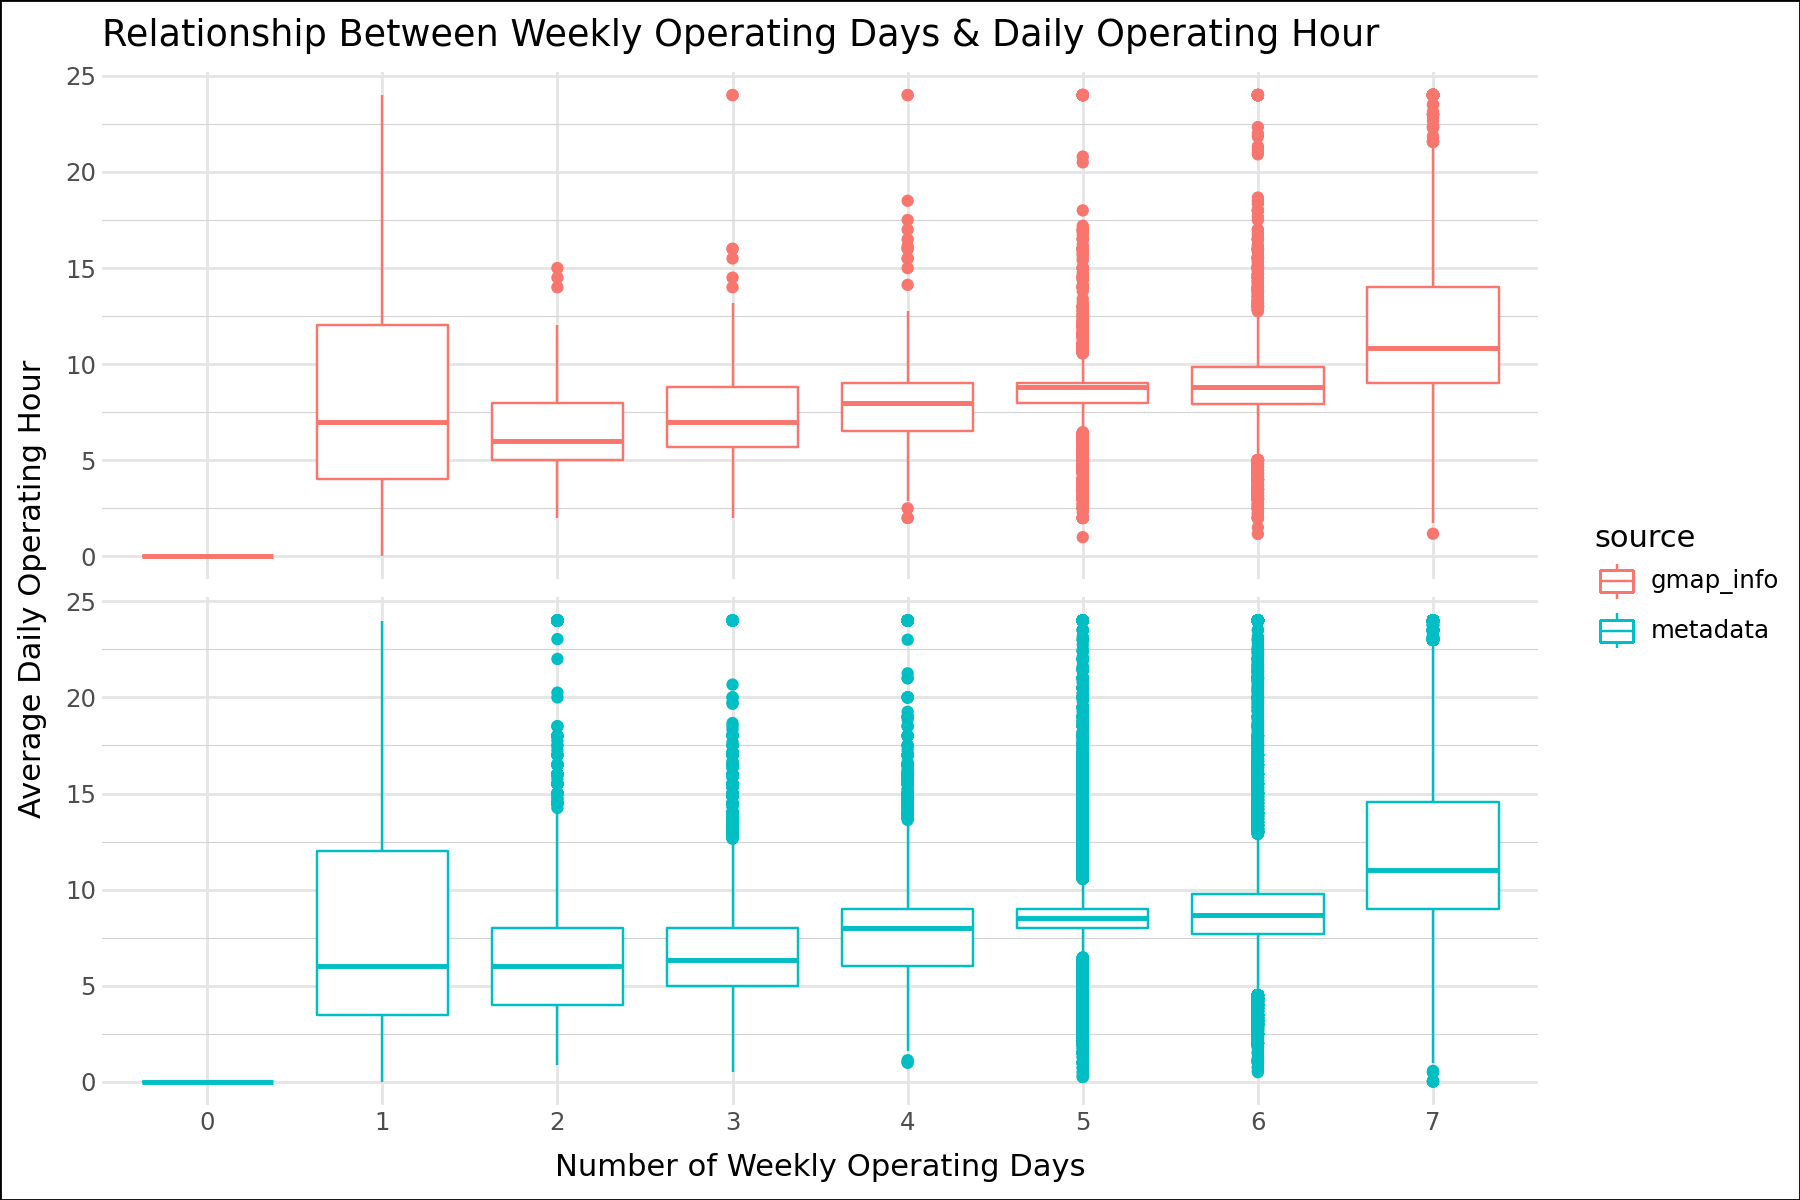

In [45]:
# Create copies of gmap_info and metadata datasets
gmap_info_temp = gmap_info.copy()
metadata_temp = metadata.copy()

# Add a 'source' column to each dataset to identify the source of data
gmap_info_temp['source'] = 'gmap_info'
metadata_temp['source'] = 'metadata'

# Concatenate the two datasets, selecting only 'operating_days', 'average_daily_hours', and 'source' columns
combined_data = pd.concat([gmap_info_temp[['operating_days', 'average_daily_hours', 'source']],
                           metadata_temp[['operating_days', 'average_daily_hours', 'source']]])

# Create a boxplot to show the relationship between the number of operating days per week and average daily operating hours
(ggplot(combined_data, aes(x = 'factor(operating_days)', y = 'average_daily_hours', colour = 'source')) +
    geom_boxplot() +
    labs(
        title='Relationship Between Weekly Operating Days & Daily Operating Hour',  # Set the plot title
        x='Number of Weekly Operating Days',  # Label for the x-axis
        y='Average Daily Operating Hour'  # Label for the y-axis
    ) +
    facet_wrap('~source', ncol = 1) +  # Use facet_wrap to display separate plots for each 'source'
    theme_minimal() +
    theme(
        figure_size = (9, 6),  # Set the figure size
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Set minor grid lines
        strip_text = element_blank()  # Hide the subplot labels (facet strip texts)
    ) 
)

Let's create separate plots for the relationship between the number of weekly operating days and the average daily operating hours using both the `gmap_info` and `metadata` datasets.

From the first plot (using `gmap_info`), we can observe the following:
- As the number of weekly operating days increases, the average daily operating hours of businesses also increase. This suggests that businesses with longer operating hours tend to be open more days per week.
- In the sample data, there are almost no businesses operating less than 3 days per week (as such businesses would likely be permanently closed).
- Businesses operating 4 to 7 days per week show a significant increase in average daily operating hours, particularly for those operating 7 days, where the distribution of average daily operating hours is wider.

The main purpose of creating the second plot (using `metadata`) is to see if the businesses in the sample data are representative of all businesses in California. From the plot, we can see that the trends are quite consistent between the two datasets, indicating that the businesses in our sample data are indeed representative.

The plot mainly indicates that businesses tend to choose longer operating hours if they want to operate more days per week, thereby increasing customer accessibility and service flexibility.

We are curious about the effectiveness of these operating models. Specifically, we want to know if such operating models have increased customer foot traffic. **We can approximate a business's foot traffic by using the review_count as a measure of the number of customers visiting the business.**

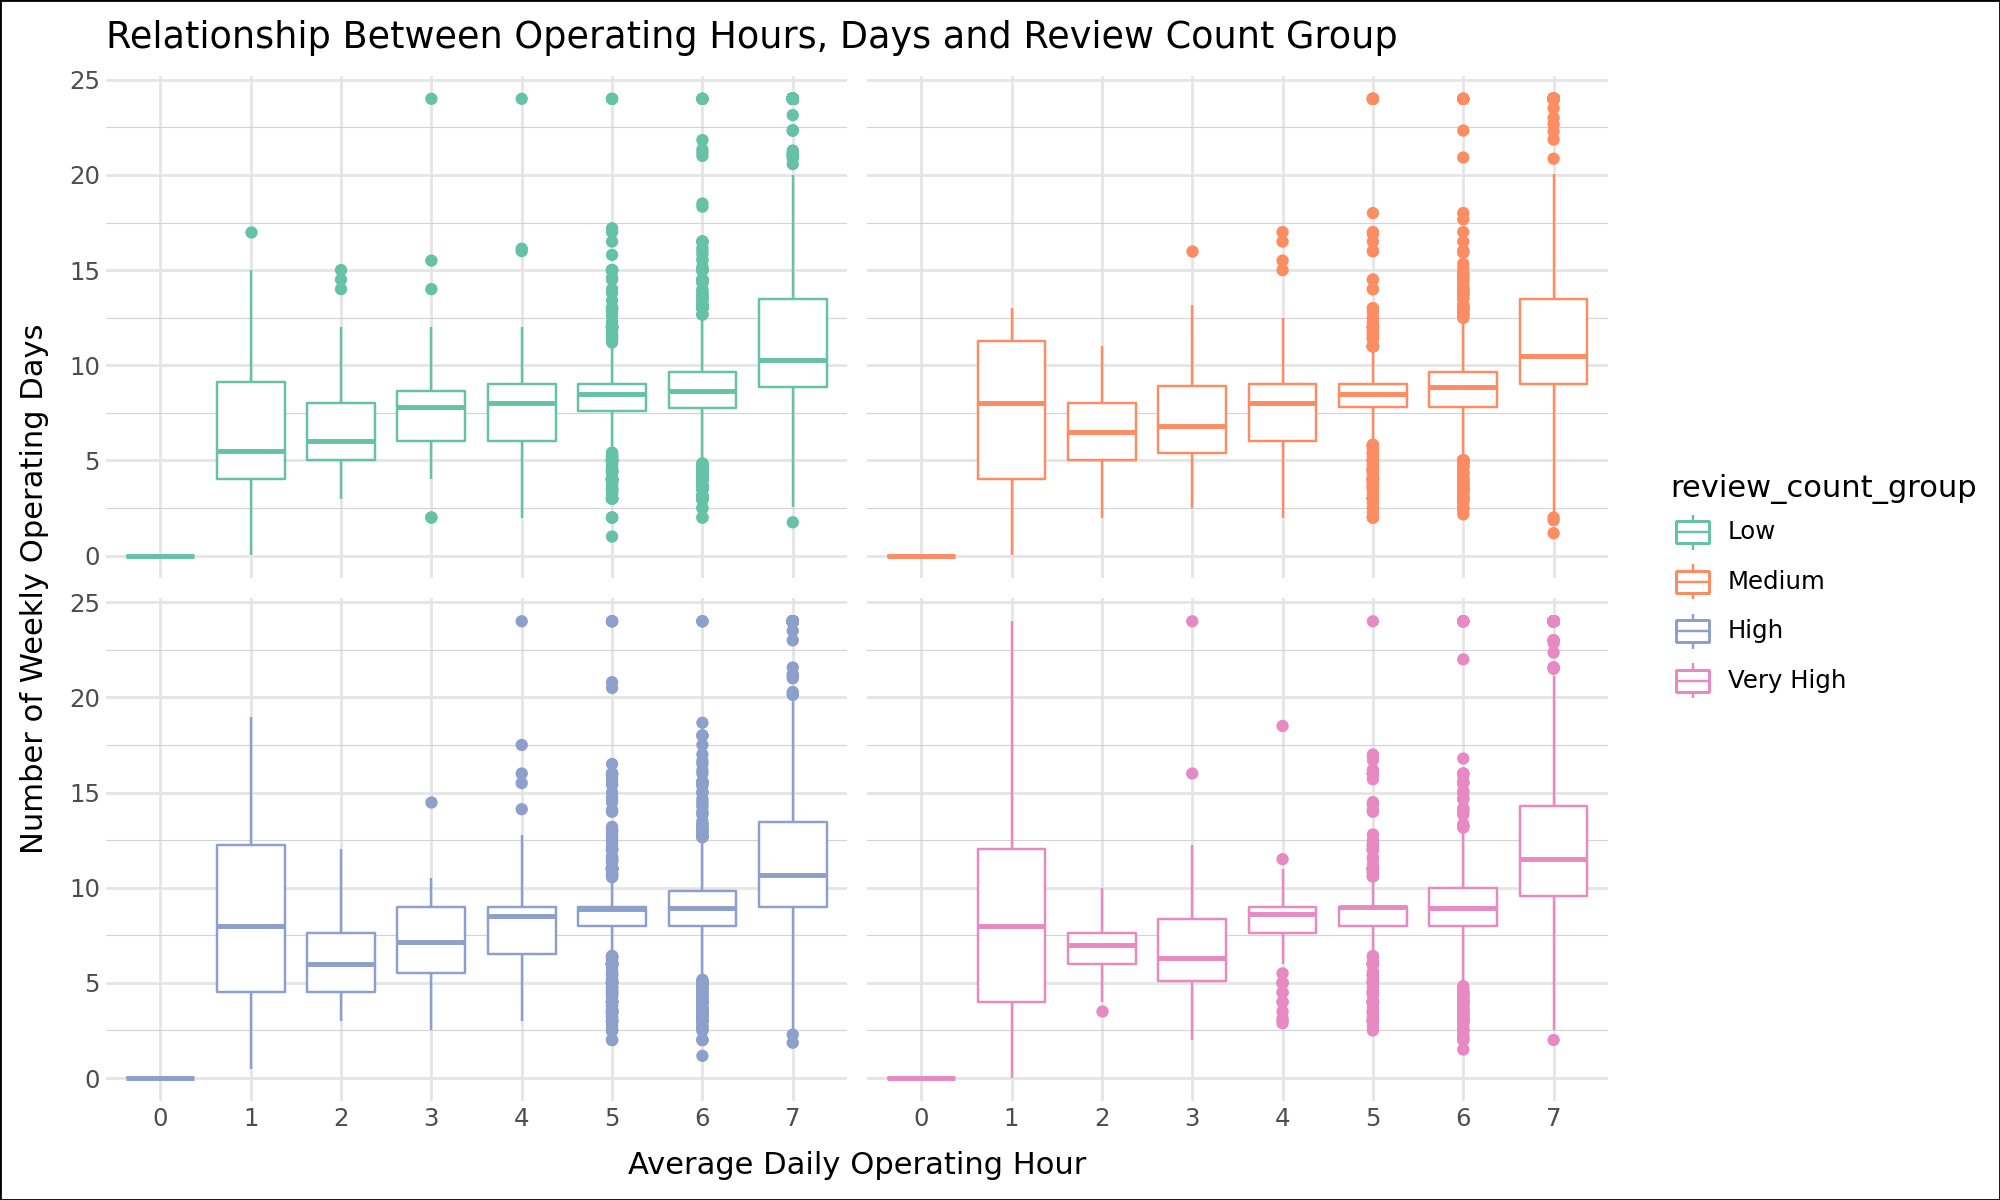

In [46]:
# Create a temporary grouping of review_count for visualization purposes
gmap_info_for_visual = gmap_info.copy()
gmap_info_for_visual['review_count_group'] = pd.qcut(gmap_info_for_visual['review_count'], q = 4, labels = ["Low", "Medium", "High", "Very High"])

# Create a boxplot to show the relationship between operating days, average daily hours, and review count group
(ggplot(gmap_info_for_visual, aes(x = 'factor(operating_days)', y = 'average_daily_hours', colour = 'review_count_group')) +
    geom_boxplot() +
    labs(
        title = 'Relationship Between Operating Hours, Days and Review Count Group',  # Set the plot title
        x = 'Average Daily Operating Hour',  # Label for the x-axis
        y = 'Number of Weekly Operating Days'  # Label for the y-axis
    ) +
    facet_wrap('~review_count_group') +  # Use facet_wrap to display separate plots for each review_count_group
    scale_color_brewer(palette = 'Set2', type = 'qual') +  # Use a color palette for better distinction between groups
    theme_minimal() +
    theme(
        figure_size = (10, 6),  # Set the figure size
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Set minor grid lines
        strip_text = element_blank()  # Hide the subplot labels (facet strip texts)
    )
)

The above plot is a faceted boxplot that displays the relationship between the number of weekly operating days and the average daily operating hours, grouped by the number of reviews a business has received. From the plot, we observe the following:

- In the Very High group, we do see some effect of this operating model, where businesses tend to have higher operating days and longer operating hours.
- However, overall, there is no significant difference in the trend of operating days and hours across the four levels of customer foot traffic.

This plot suggests that the business model of extending operating hours to increase customer visits has not significantly boosted foot traffic. Customer traffic is likely influenced by other factors, such as the business's location, service quality, marketing strategies, and more, rather than just the length of operating hours and the number of operating days.

Let's further investigate whether the city in which a business is located and its price range have an impact on customer foot traffic.

C:\Users\zyyin1\AppData\Local\Temp\ipykernel_90644\915218997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zyyin1\AppData\Local\Temp\ipykernel_90644\915218997.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


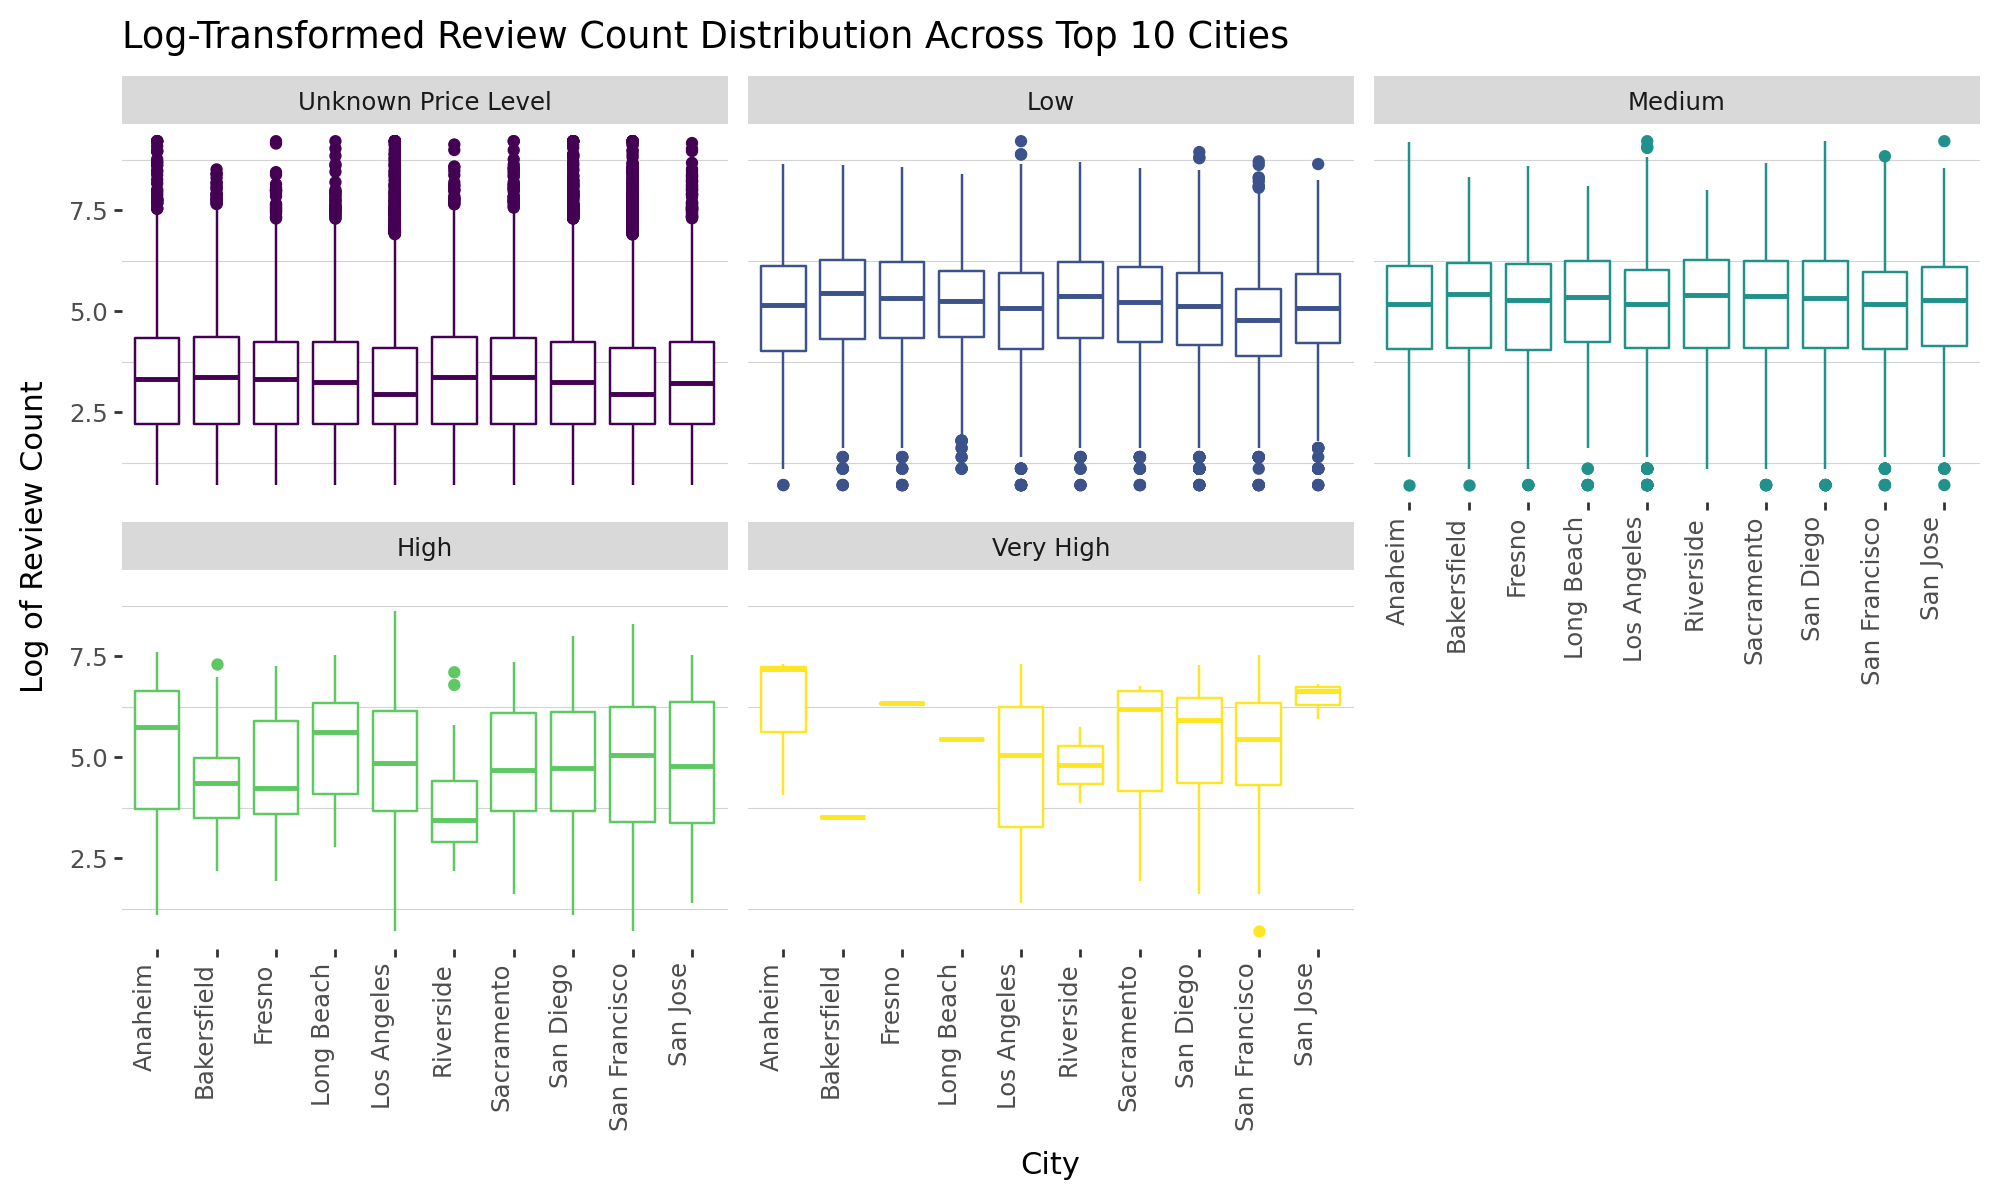

In [47]:
# Aggregate the data to calculate the total number of reviews for each city
city_review_count = metadata.groupby('city')['num_of_reviews'].sum()

# Select the top 10 cities with the highest total review counts
top_cities = city_review_count.nlargest(10).index

# Filter the data to keep only the records from the top 10 cities
filtered_data = metadata[metadata['city'].isin(top_cities)]

# Apply a logarithmic transformation to the number of reviews to normalize the distribution
filtered_data['log_num_of_reviews'] = np.log1p(filtered_data['num_of_reviews'])

# Set the 'price_level' column as an ordered categorical variable, defining the order
price_level_order = ['Unknown Price Level', 'Low', 'Medium', 'High', 'Very High']
filtered_data['price_level'] = pd.Categorical(filtered_data['price_level'], categories=price_level_order, ordered=True)

# Create a boxplot to visualize the log-transformed review count distribution across the top 10 cities, faceted by price level
(ggplot(filtered_data, aes(x = 'city', y = 'log_num_of_reviews', color = 'price_level')) +
    geom_boxplot() +
    labs(
        title = 'Log-Transformed Review Count Distribution Across Top 10 Cities',  # Set the plot title
        x = 'City',  # Label for the x-axis
        y = 'Log of Review Count'  # Label for the y-axis
    ) +
    facet_wrap('~price_level') +  # Facet the plot by price level
    theme(
        figure_size = (10, 6),  # Set the figure size
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Set minor grid lines
        axis_text_x = element_text(rotation = 90, hjust = 1),  # Rotate x-axis labels to prevent overlap
        legend_position = "none"  # Hide the legend
    )
)

This plot shows the distribution of review counts in the top 10 cities, with businesses categorized by different price ranges. By applying a logarithmic transformation to the review counts, we can more clearly observe the impact of a business's city and price range on customer foot traffic (approximated by review counts). From the plot, we observe the following:

- **Unknown Price Level, Low & Medium Price Level**: For businesses in these three price ranges, the distribution of review counts across different cities is relatively even, with no significant differences observed.
- **High & Very High Price Level**: For businesses in the high and very high price ranges, there is a noticeable variation in the distribution of review counts. Particularly in the Very High price range, businesses, although fewer in number, stand out in certain cities like Anaheim, possibly indicating a stronger market demand for high-priced businesses in these locations.

Overall, there are clear differences in customer foot traffic distribution among businesses in different cities, especially in the higher price ranges. The impact of price range on customer foot traffic is also significant (e.g., location and price range). Depending on the price range and city, businesses may consider adjusting their pricing strategies to better meet the demands of their target market.

## 3.2 Analyzing from the User Perspective

We are very interested in the number of times a business has been recommended on Google Maps (`times_recommended`). Let's first take a look at its distribution.

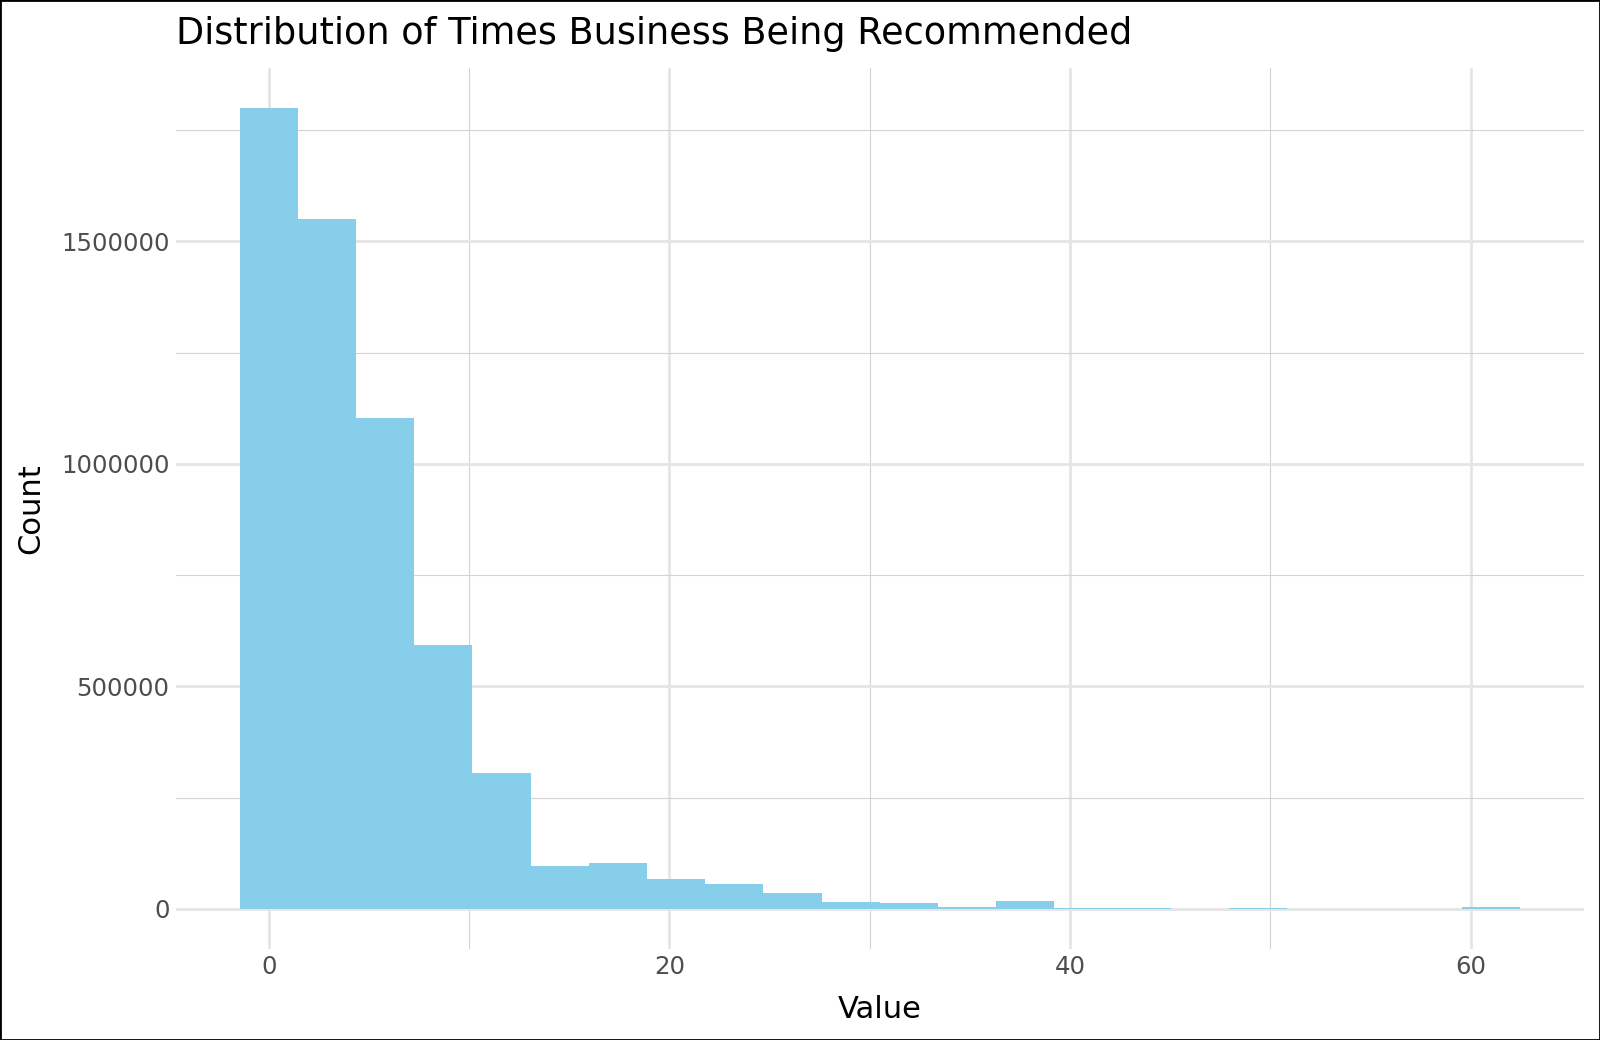

In [48]:
# Plotting the histogram for the distribution of review text length, number of pictures, and review time (by year)
(ggplot(gmap_reviews, mapping = aes(x = 'times_recommended')) +
    geom_histogram(bins = 22, fill = 'skyblue') +  # Create a histogram with 20 bins, colored by variable
    labs(
        title = 'Distribution of Times Business Being Recommended',  # Add a title to the plot
        x = 'Value',  # Label for the x-axis
        y = 'Count'   # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4)  # Style the minor grid lines
    )
)

From the plot, we can observe the following:

- The majority of businesses have been recommended fewer than 5 times. These businesses have been recommended to some extent, but not frequently.
- As the number of recommendations increases, the number of businesses gradually decreases. Very few businesses have been recommended more than 10 times, indicating that among the recommended businesses, only a small number receive frequent recommendations.

We can see that most businesses have low exposure in the recommendation system, with only a few enjoying a high number of recommendations.

Next, we'll analyze the relationship between users and the Google Maps recommendation system, focusing on user behavior and influence. Specifically, we'll:

- Calculate the number of reviews each user has posted to identify "high-frequency reviewers" and then analyze whether these users tend to give higher or lower ratings.
- Calculate the total number of reviews each user has posted and the corresponding times the businesses they reviewed have been recommended. This will help us identify which users' reviews have a significant impact on the businesses' recommendation frequency in the system.

Let's start by identifying those users who frequently post reviews, i.e., the "high-frequency reviewers."

In [49]:
# Calculate the number of reviews each user has posted
user_review_counts = gmap_reviews.groupby('user_id').size().reset_index(name = 'review_count')

# Define the threshold for high-frequency reviewers, e.g., users with more than 10 reviews
high_frequency_threshold = 10
high_frequency_users = user_review_counts[user_review_counts['review_count'] > high_frequency_threshold]

# Print the number of high-frequency reviewers
print(f"Number of high-frequency reviewers: {high_frequency_users.shape[0]}")

Number of high-frequency reviewers: 30272


In [50]:
# Define the threshold for high-frequency reviewers, e.g., users with more than 2 reviews
high_frequency_threshold = 2
high_frequency_users = user_review_counts[user_review_counts['review_count'] > high_frequency_threshold]

# Print the number of high-frequency reviewers
print(f"Number of high-frequency reviewers: {high_frequency_users.shape[0]}")

Number of high-frequency reviewers: 436922


The above finding is quite disappointing for us. If we set the `high_frequency_threshold` to 2, we can only identify 9 users in total. If we set the threshold to 5, we can't find a single user. This is far below our expectations.

Let's check the number of rows in `gmap_reviews` and the number of unique users.

In [51]:
# Calculate the number of unique users
num_users = gmap_reviews.index.get_level_values('user_id').nunique()

# Print the number of reviews (rows) in gmap_reviews
print(f'Number of reviews: {len(gmap_reviews)}')

# Print the number of unique users
print(f'Number of unique users: {num_users}')

Number of reviews: 5767463
Number of unique users: 3457903


Out of 35,275 reviews, there are 34,921 unique users. This means that the vast majority of users have left only one review, making it less representative or meaningful to analyze their reviewing patterns (such as whether they tend to give high or low ratings). It is challenging to extract significant patterns or trends from this data. In other words, we believe it is difficult to conduct user-based analysis using the sample data.

However, we believe that discovering that "user-based analysis is difficult" is itself an important finding. Let's break down this disappointing discovery step by step:

1. In our sample data, we collected a total of 35,275 reviews, which were provided by 34,921 unique users. On average, each user has posted only 1.01 reviews, indicating a high level of dispersion and sparsity in user review behavior.

2. Since most users have only provided one review, it is challenging to analyze behavior patterns at the user level. Even when setting a low "high-frequency user" threshold (e.g., 2 reviews), we can only identify 9 users. This falls short of our usual goal of identifying useful patterns from an active user base.

3. This stands in stark contrast to platforms with strong social attributes, such as social media. The low frequency of interaction suggests that Google Maps has almost no social attributes. Users primarily use it as a tool to obtain information rather than as a social platform for frequent interaction.

4. The lack of social attributes limits the effectiveness of Google Maps' recommendation system. Social media platforms' recommendation systems often rely on users' social relationships and consumption behaviors. In contrast, Google Maps lacks these social dimensions of data, making its recommendation system less effective compared to social media.

Overall, this sample Google Maps review data reflects a lack of social attributes, which directly limits the effectiveness and monetization potential of its recommendation system.

Let's create a plot of the relationship between Review Rating and Times Business Being Recommended to further validate our hypothesis.

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_boxplot : Removed 10383 rows containing non-finite values.


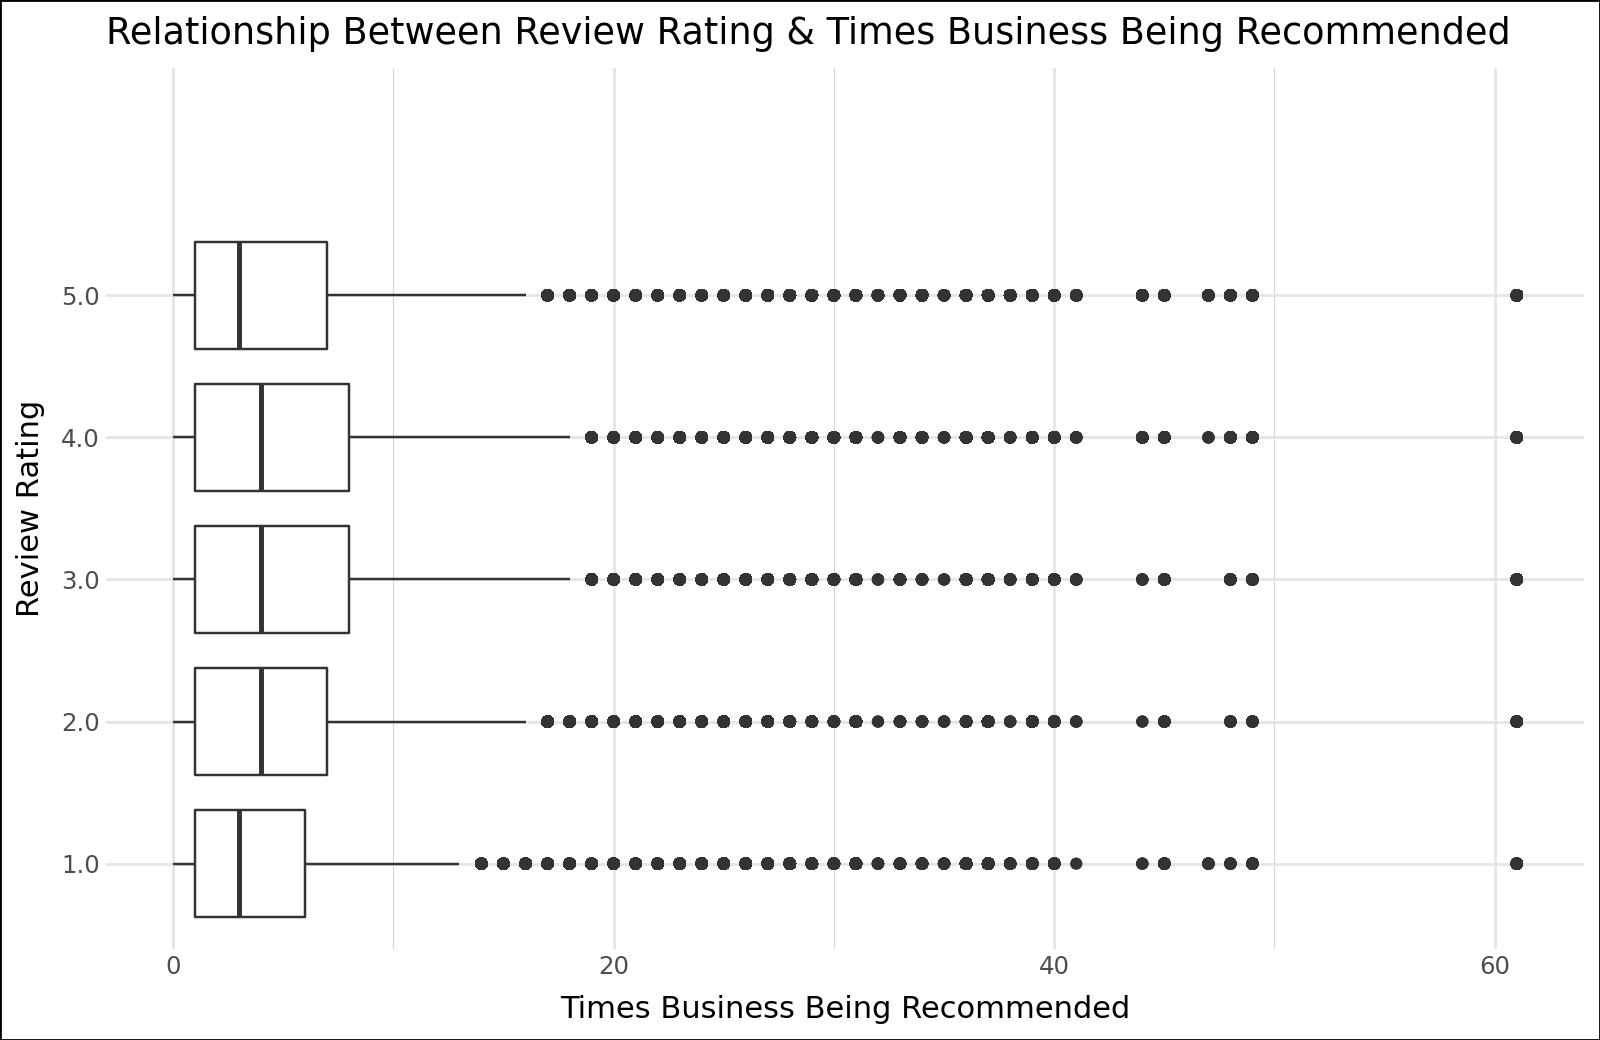

In [52]:
# Create a boxplot to visualize the distribution of review text length across different ratings
(ggplot(gmap_reviews, mapping = aes(x = 'factor(review_rating)', y = 'times_recommended')) +
    geom_boxplot() +  # Add a boxplot layer to the plot
    labs(
        title = 'Relationship Between Review Rating & Times Business Being Recommended',  # Add a title to the plot
        x = 'Review Rating',  # Label for the x-axis
        y = 'Times Business Being Recommended'  # Label for the y-axis
    ) +
    coord_flip() +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Style the minor grid lines
    )
)

The above plot shows that as the number of times a business is recommended increases, the review ratings given by users do not significantly improve.

Remember that we approximated Review Count as customer foot traffic earlier? Let's create a plot to explore the relationship between Review Count and Times Business Being Recommended.

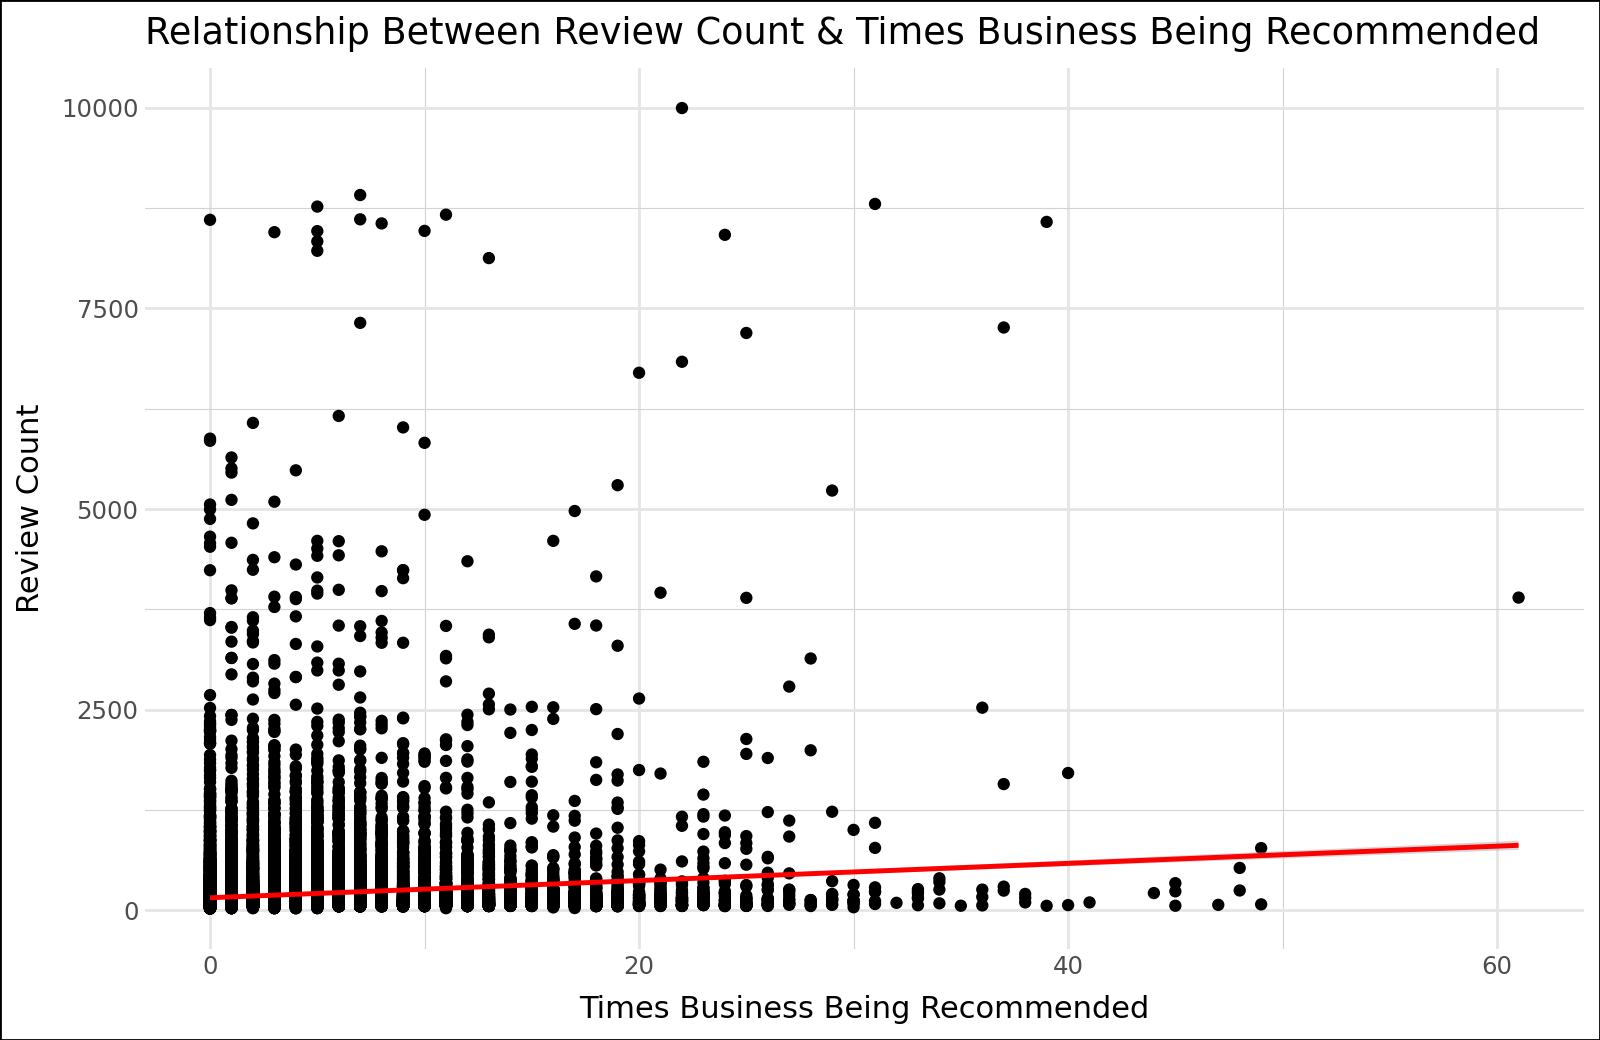

In [53]:
# Create a boxplot to visualize the distribution of review text length across different ratings
(ggplot(gmap_info, mapping = aes(x = 'times_recommended', y = 'review_count')) +
    geom_point() +  # Add a boxplot layer to the plot
    geom_smooth(color = 'red') +
    labs(
        title = 'Relationship Between Review Count & Times Business Being Recommended',  # Add a title to the plot
        x = 'Times Business Being Recommended',  # Label for the x-axis
        y = 'Review Count'  # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4),  # Style the minor grid lines
    )
)

The above plot reveals a significant phenomenon: although the number of recommendations for certain businesses has increased, their review count has not correspondingly risen.

These charts further support our perspective: in its current form, Google Maps' recommendation system has not successfully converted the number of recommendations into actual customer traffic or improved customer ratings for businesses. The effectiveness of Google Maps' recommendation system is limited by the lack of strong social attributes. Compared to recommendation systems that heavily rely on social interactions, Google Maps' recommendation feature may fall short in driving user behavior.

If Google Maps aims to enhance the effectiveness of its business model through its recommendation system, it might need to increase social interaction features to improve the real impact of recommendations.

<div class="alert alert-block alert-success">

# Step 4: Summary of Meaningful Insights <a id='optimized_loading'></a>

</div>

This step 4 contains the relatively meaningful insights found in this task. This step also serves as the presentation content of our task 4 video presentation. We put it here for the teaching team to refer to.

## Introduction

Context of Analysis

This assignment involves analysis of datasets derived from Google Maps, focusing on both business and user perspectives. The goal is to uncover meaningful insights by exploring review patterns, metadata, and the potential impact of Google Maps' business model on its recommendation system. 

Datasets Used:
1. Business Information From Main Google Review Data
2. Review Information From Main Google Review Data
2. MetaData
3. Combination of them

## Methodology

- For the Pre-Processing, we perform data integration & split, converting data type and some feature engineering.
- For the Analysis, we divide the analysis into two parts: first, univariate analysis on the datasets, and then multivariate analysis. Multivariate analysis is divided into two perspectives: business and user. We frequently use visualization throughout the process to help better understand the findings.

## Insights

Here're 5 relatively meaningful insights we find.

**Insight 1**:

We observe significant differences in the number of reviews given at different hours of a day. 


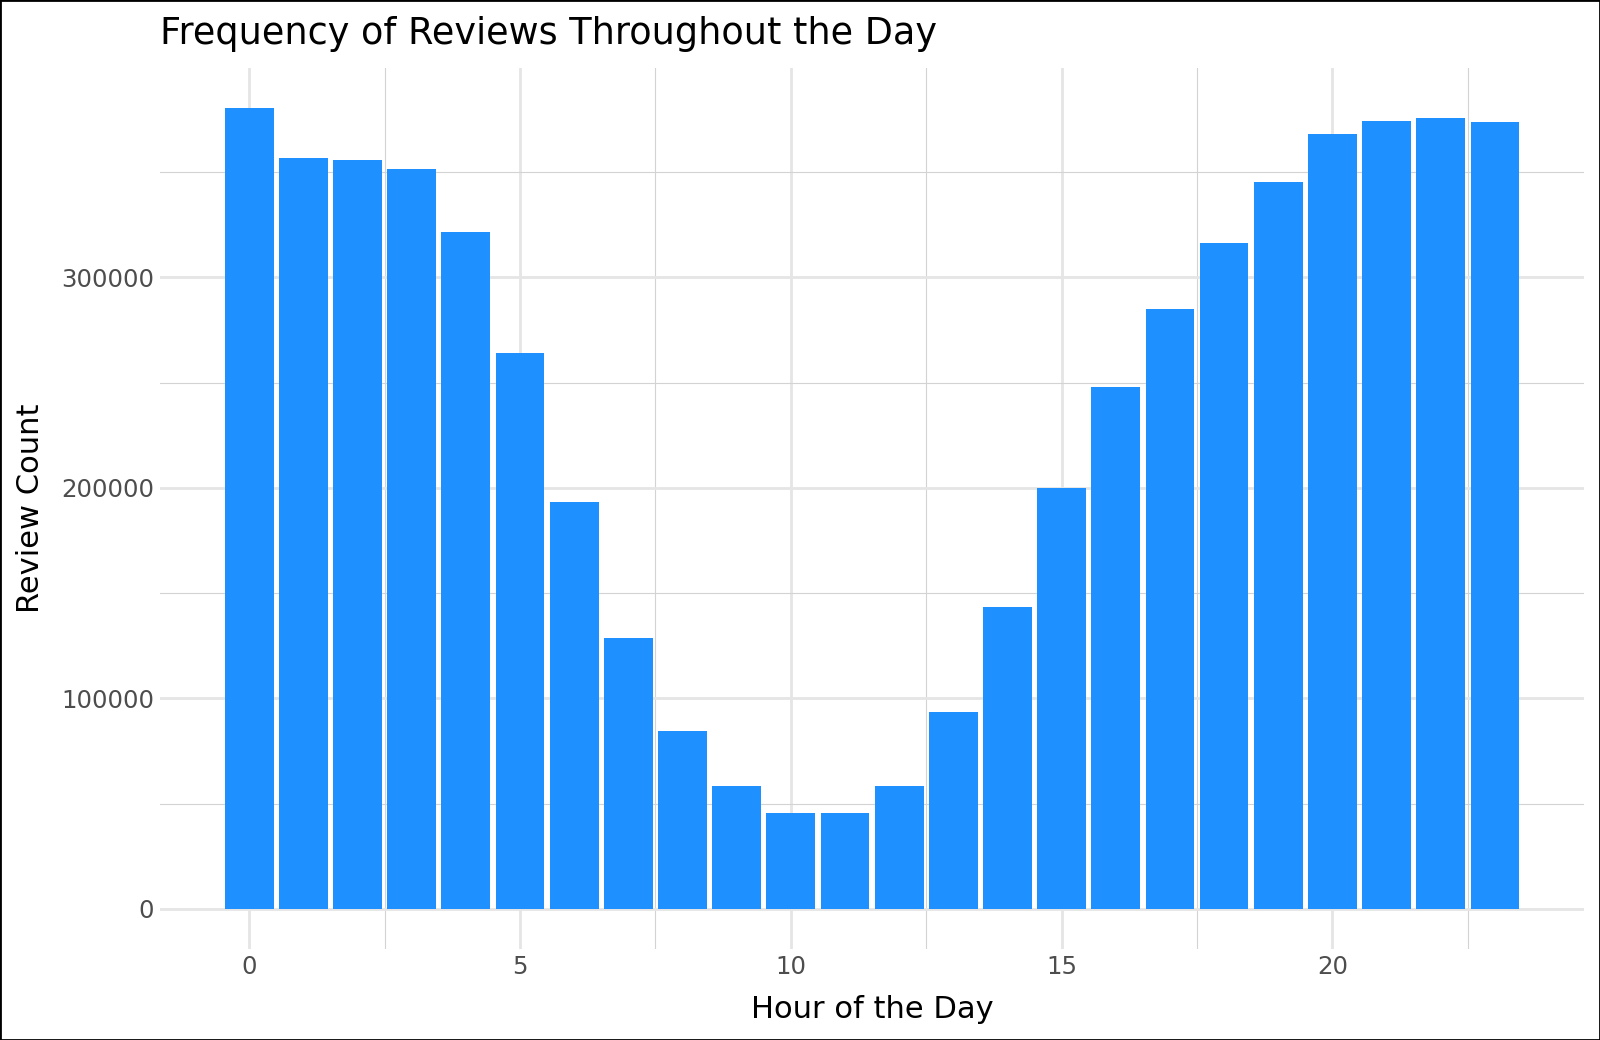

In [54]:
# Create a bar plot to visualize the frequency of reviews throughout the day
(ggplot(gmap_reviews_for_visual, mapping = aes(x = 'hour')) +
    geom_bar(fill = 'dodgerblue') +  # Create a bar plot with bars filled in 'dodgerblue' color
    labs(
        title = 'Frequency of Reviews Throughout the Day',  # Add a title to the plot
        x = 'Hour of the Day',  # Label for the x-axis
        y = 'Review Count'  # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size = (8, 5.2),  # Set the size of the figure
        panel_background = element_rect(fill = 'white'),  # Set the panel background color to white
        plot_background = element_rect(fill = 'white'),  # Set the overall plot background color to white
        plot_title = element_text(hjust = 0),  # Align the plot title to the left
        panel_grid_minor = element_line(color = 'lightgrey', size = 0.4)  # Style the minor grid lines
    )
)

This bar chart shows review counts peak during the midnight to early morning hours, decrease significantly in the morning, and rise again in the afternoon and evening. Overall, users tend to leave reviews outside of work hours, which aligns with typical daily routines.

**Insight 2**:

We find businesses tend to choose longer operating hours if they want to operate more days per week, thereby increasing customer accessibility.

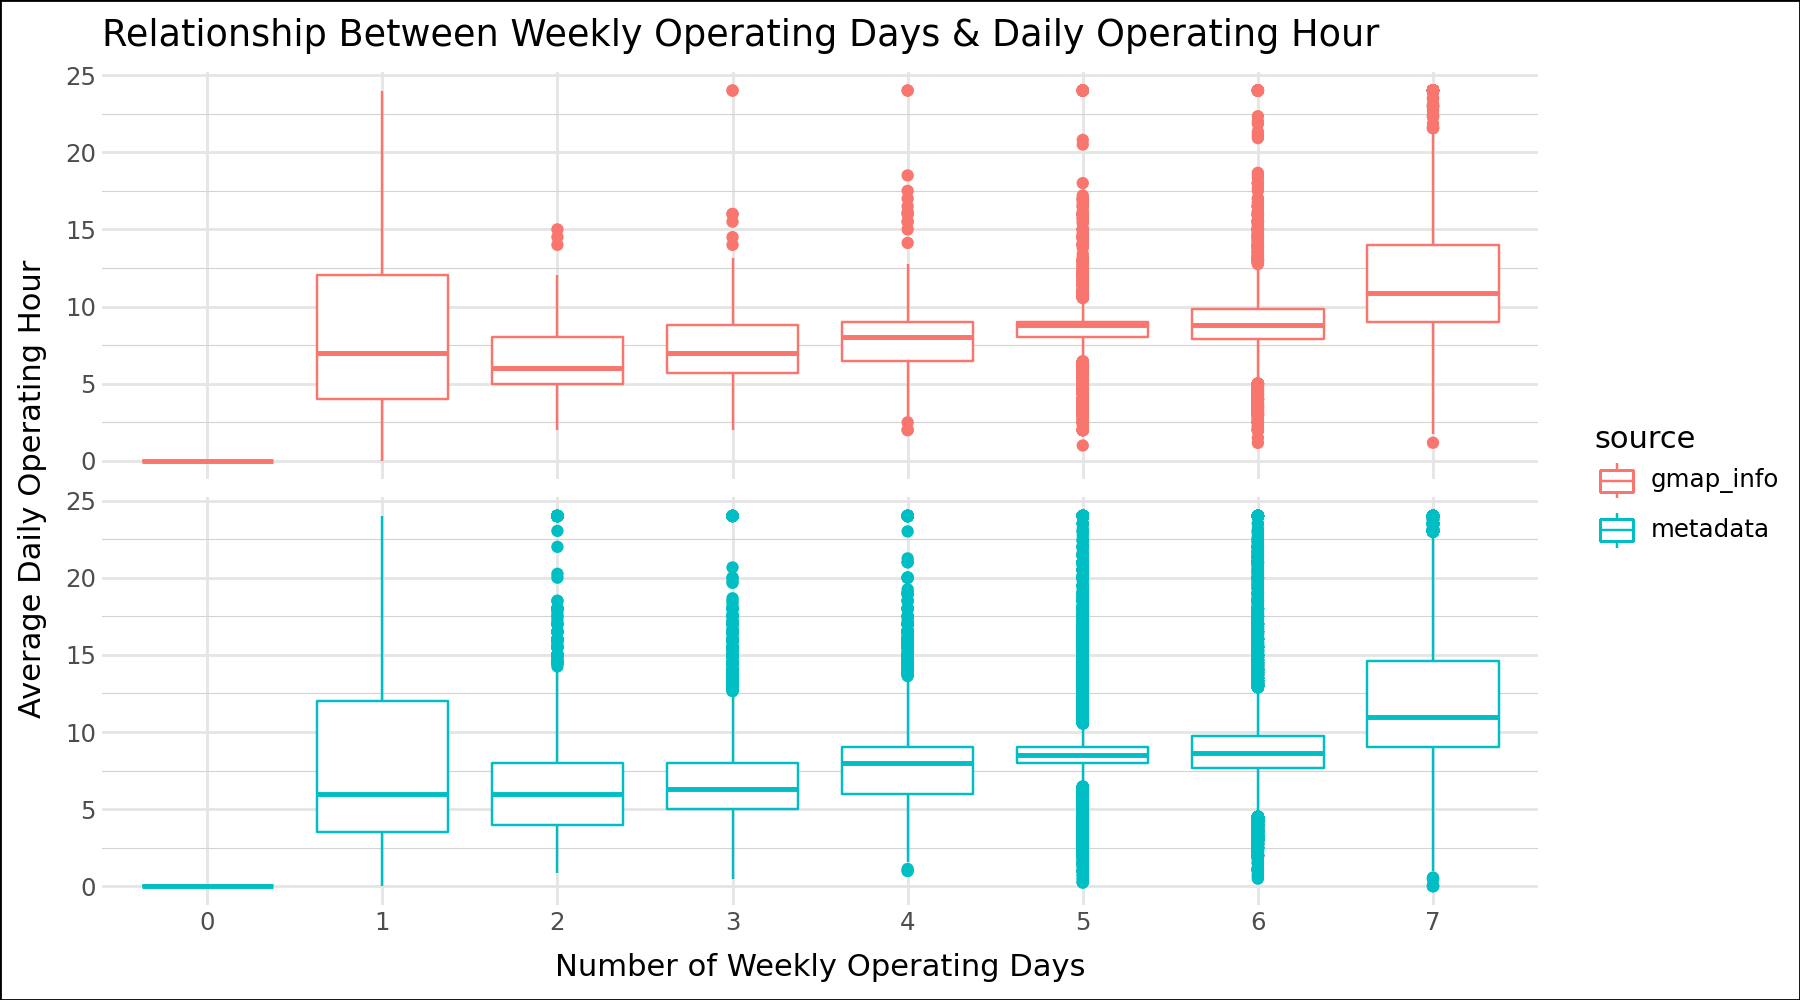

In [55]:
# Create copies of gmap_info and metadata datasets
gmap_info_temp = gmap_info.copy()
metadata_temp = metadata.copy()

# Add a 'source' column to each dataset to identify the source of data
gmap_info_temp['source'] = 'gmap_info'
metadata_temp['source'] = 'metadata'

# Concatenate the two datasets, selecting only 'operating_days', 'average_daily_hours', and 'source' columns
combined_data = pd.concat([gmap_info_temp[['operating_days', 'average_daily_hours', 'source']],
                           metadata_temp[['operating_days', 'average_daily_hours', 'source']]])

# Create a boxplot to show the relationship between the number of operating days per week and average daily operating hours
(ggplot(combined_data, aes(x='factor(operating_days)', y='average_daily_hours', colour='source')) +
    geom_boxplot() +
    labs(
        title='Relationship Between Weekly Operating Days & Daily Operating Hour',  # Set the plot title
        x='Number of Weekly Operating Days',  # Label for the x-axis
        y='Average Daily Operating Hour'  # Label for the y-axis
    ) +
    facet_wrap('~source', ncol=1) +  # Use facet_wrap to display separate plots for each 'source'
    theme_minimal() +
    theme(
        figure_size=(9, 5),  # Set the figure size
        panel_background=element_rect(fill='white'),  # Set the panel background color to white
        plot_background=element_rect(fill='white'),  # Set the plot background color to white
        plot_title=element_text(hjust=0),  # Align the plot title to the left
        panel_grid_minor=element_line(color='lightgrey', size=0.4),  # Set minor grid lines
        strip_text=element_blank()  # Hide the subplot labels (facet strip texts)
    ) 
)

We created separate plots for the relationship between the number of weekly days and the average daily hours using the main data & metadata.

For the red plot from main data, we find that as the number of weekly operating days increases, the average daily hours of businesses also increase. This trend is consistent across both datasets, which means that our sample data is representative.

**Insight 2.1**:

We use review count as a measuremeant of foot traffic, and find the operating model shown above cannot significantly boost foot traffic.

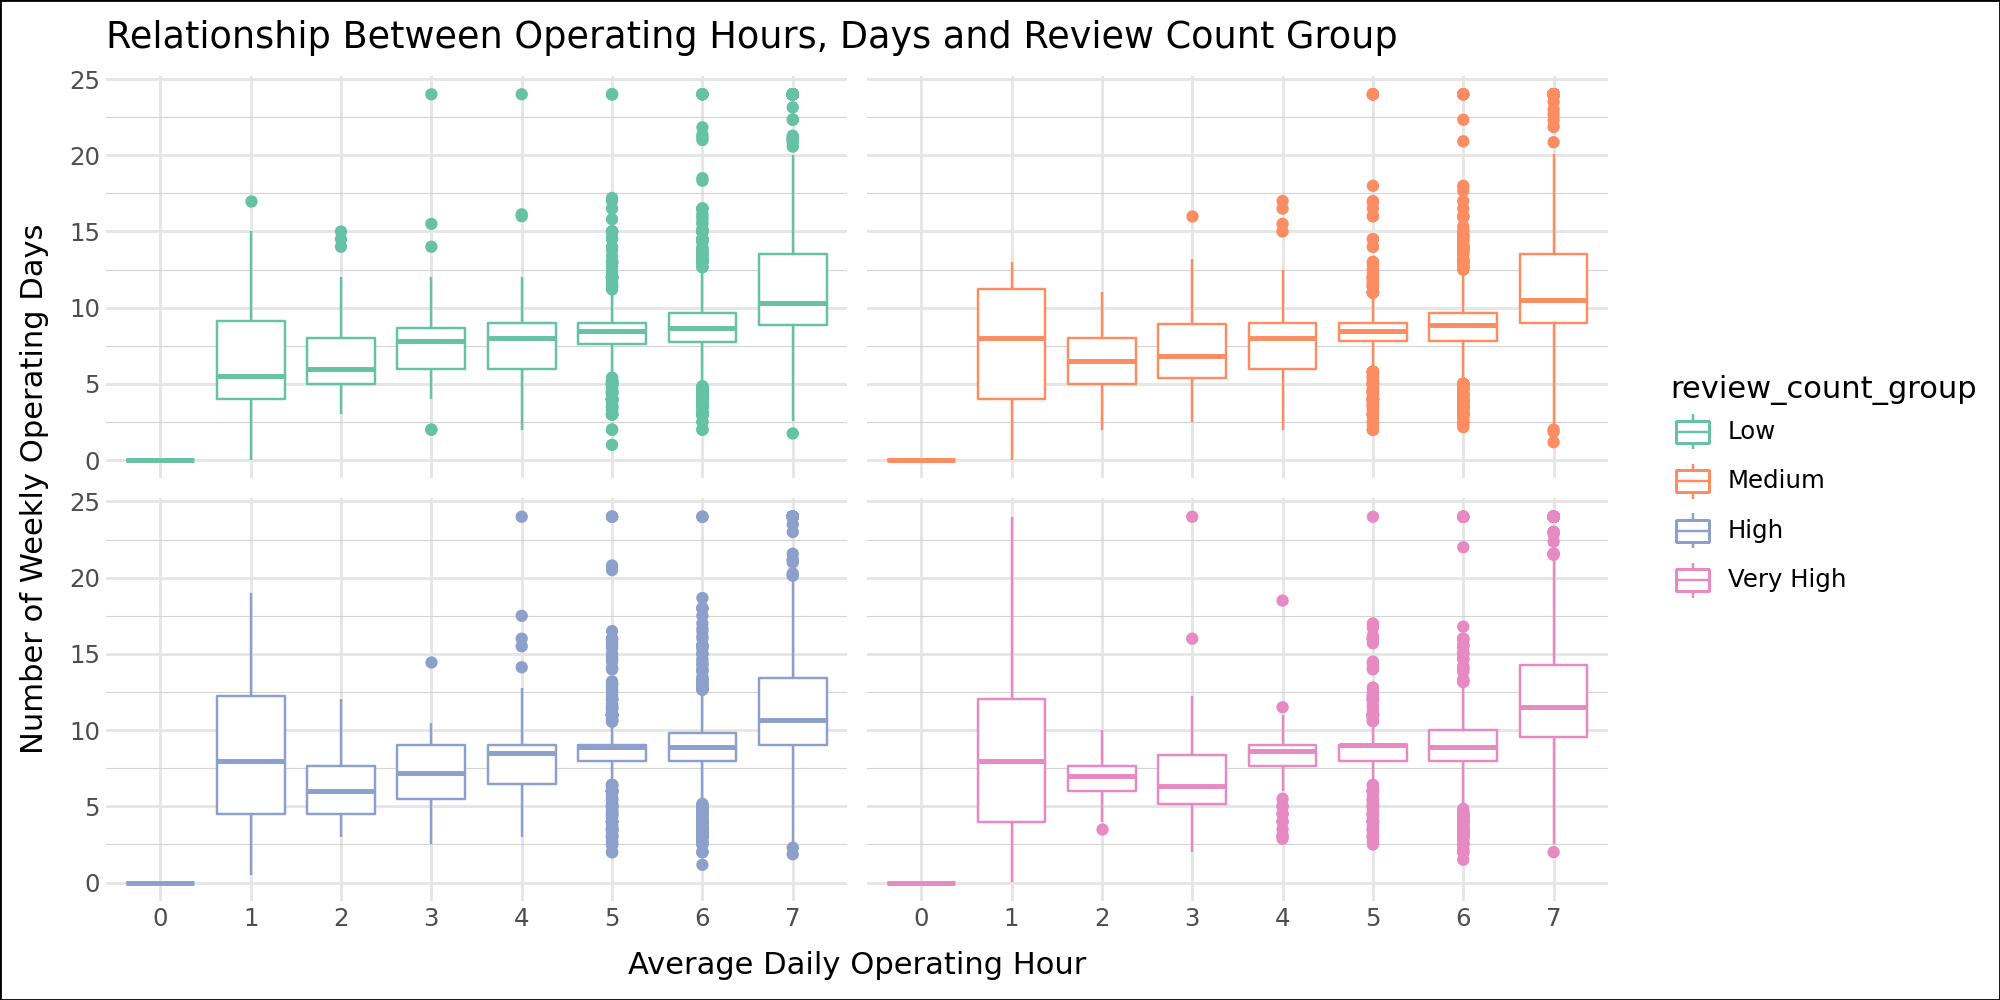

In [56]:
# Create a temporary grouping of review_count for visualization purposes
gmap_info_for_visual = gmap_info.copy()
gmap_info_for_visual['review_count_group'] = pd.qcut(gmap_info_for_visual['review_count'], q=4, labels=["Low", "Medium", "High", "Very High"])

# Create a boxplot to show the relationship between operating days, average daily hours, and review count group
(ggplot(gmap_info_for_visual, aes(x='factor(operating_days)', y='average_daily_hours', colour='review_count_group')) +
    geom_boxplot() +
    labs(
        title='Relationship Between Operating Hours, Days and Review Count Group',  # Set the plot title
        x='Average Daily Operating Hour',  # Label for the x-axis
        y='Number of Weekly Operating Days'  # Label for the y-axis
    ) +
    facet_wrap('~review_count_group') +  # Use facet_wrap to display separate plots for each review_count_group
    scale_color_brewer(palette='Set2', type='qual') +  # Use a color palette for better distinction between groups
    theme_minimal() +
    theme(
        figure_size=(10, 5),  # Set the figure size
        panel_background=element_rect(fill='white'),  # Set the panel background color to white
        plot_background=element_rect(fill='white'),  # Set the plot background color to white
        plot_title=element_text(hjust=0),  # Align the plot title to the left
        panel_grid_minor=element_line(color='lightgrey', size=0.4),  # Set minor grid lines
        strip_text=element_blank()  # Hide the subplot labels (facet strip texts)
    )
)

The above figure is divided by review count, and we can see there's almost no difference in the trends of the 4 review count categories. This also shows customer traffic is more likely to be affected by other features.

**Insight 2.2**:

We find there're clear differences in customer foot traffic distribution in different cities & price levels.

C:\Users\zyyin1\AppData\Local\Temp\ipykernel_90644\4050200038.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zyyin1\AppData\Local\Temp\ipykernel_90644\4050200038.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


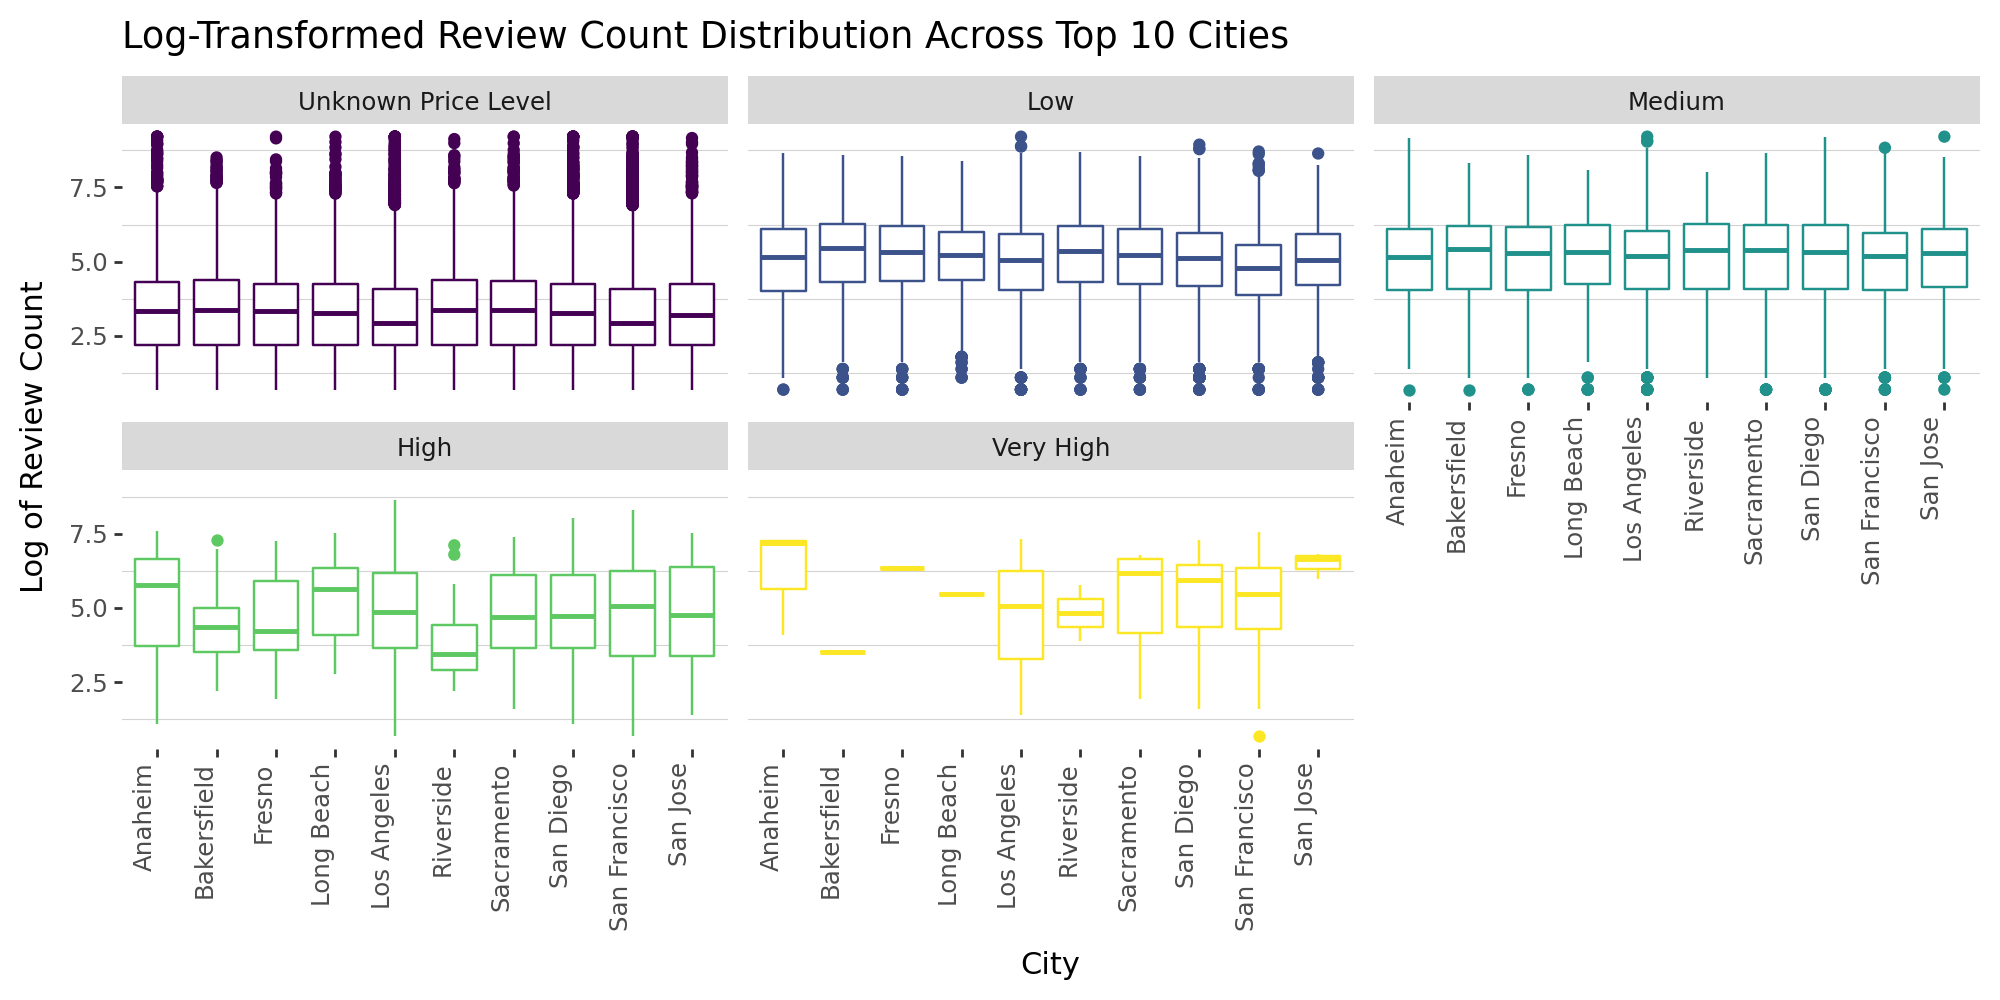

In [57]:
# Aggregate the data to calculate the total number of reviews for each city
city_review_count = metadata.groupby('city')['num_of_reviews'].sum()

# Select the top 10 cities with the highest total review counts
top_cities = city_review_count.nlargest(10).index

# Filter the data to keep only the records from the top 10 cities
filtered_data = metadata[metadata['city'].isin(top_cities)]

# Apply a logarithmic transformation to the number of reviews to normalize the distribution
filtered_data['log_num_of_reviews'] = np.log1p(filtered_data['num_of_reviews'])

# Set the 'price_level' column as an ordered categorical variable, defining the order
price_level_order = ['Unknown Price Level', 'Low', 'Medium', 'High', 'Very High']
filtered_data['price_level'] = pd.Categorical(filtered_data['price_level'], categories=price_level_order, ordered=True)

# Create a boxplot to visualize the log-transformed review count distribution across the top 10 cities, faceted by price level
(ggplot(filtered_data, aes(x='city', y='log_num_of_reviews', color='price_level')) +
    geom_boxplot() +
    labs(
        title='Log-Transformed Review Count Distribution Across Top 10 Cities',  # Set the plot title
        x='City',  # Label for the x-axis
        y='Log of Review Count'  # Label for the y-axis
    ) +
    facet_wrap('~price_level') +  # Facet the plot by price level
    theme(
        figure_size=(10, 5),  # Set the figure size
        panel_background=element_rect(fill='white'),  # Set the panel background color to white
        plot_background=element_rect(fill='white'),  # Set the plot background color to white
        plot_title=element_text(hjust=0),  # Align the plot title to the left
        panel_grid_minor=element_line(color='lightgrey', size=0.4),  # Set minor grid lines
        axis_text_x=element_text(rotation=90, hjust=1),  # Rotate x-axis labels to prevent overlap
        legend_position="none"  # Hide the legend
    )
)

This plot shows the distribution of review counts in the top 10 cities, with respective to different price levels. By applying a log transformation to the review counts, we can more clearly observe the impact of city and price level on customer foot traffic.

**Insight 3**:

During the user-based analysis, we find that, on average, each user has only 1.1 reviews.

In [58]:
# Calculate the number of unique users
num_users = gmap_reviews.index.get_level_values('user_id').nunique()

# Print the number of reviews (rows) in gmap_reviews
print(f'Number of reviews: {len(gmap_reviews)}')

# Print the number of unique users
print(f'Number of unique users: {num_users}')

Number of reviews: 5767463
Number of unique users: 3457903


This indicates that Google Map lacks social attributes, making its recommendation system ineffective in boosting business customer traffic and ratings.

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_boxplot : Removed 10383 rows containing non-finite values.


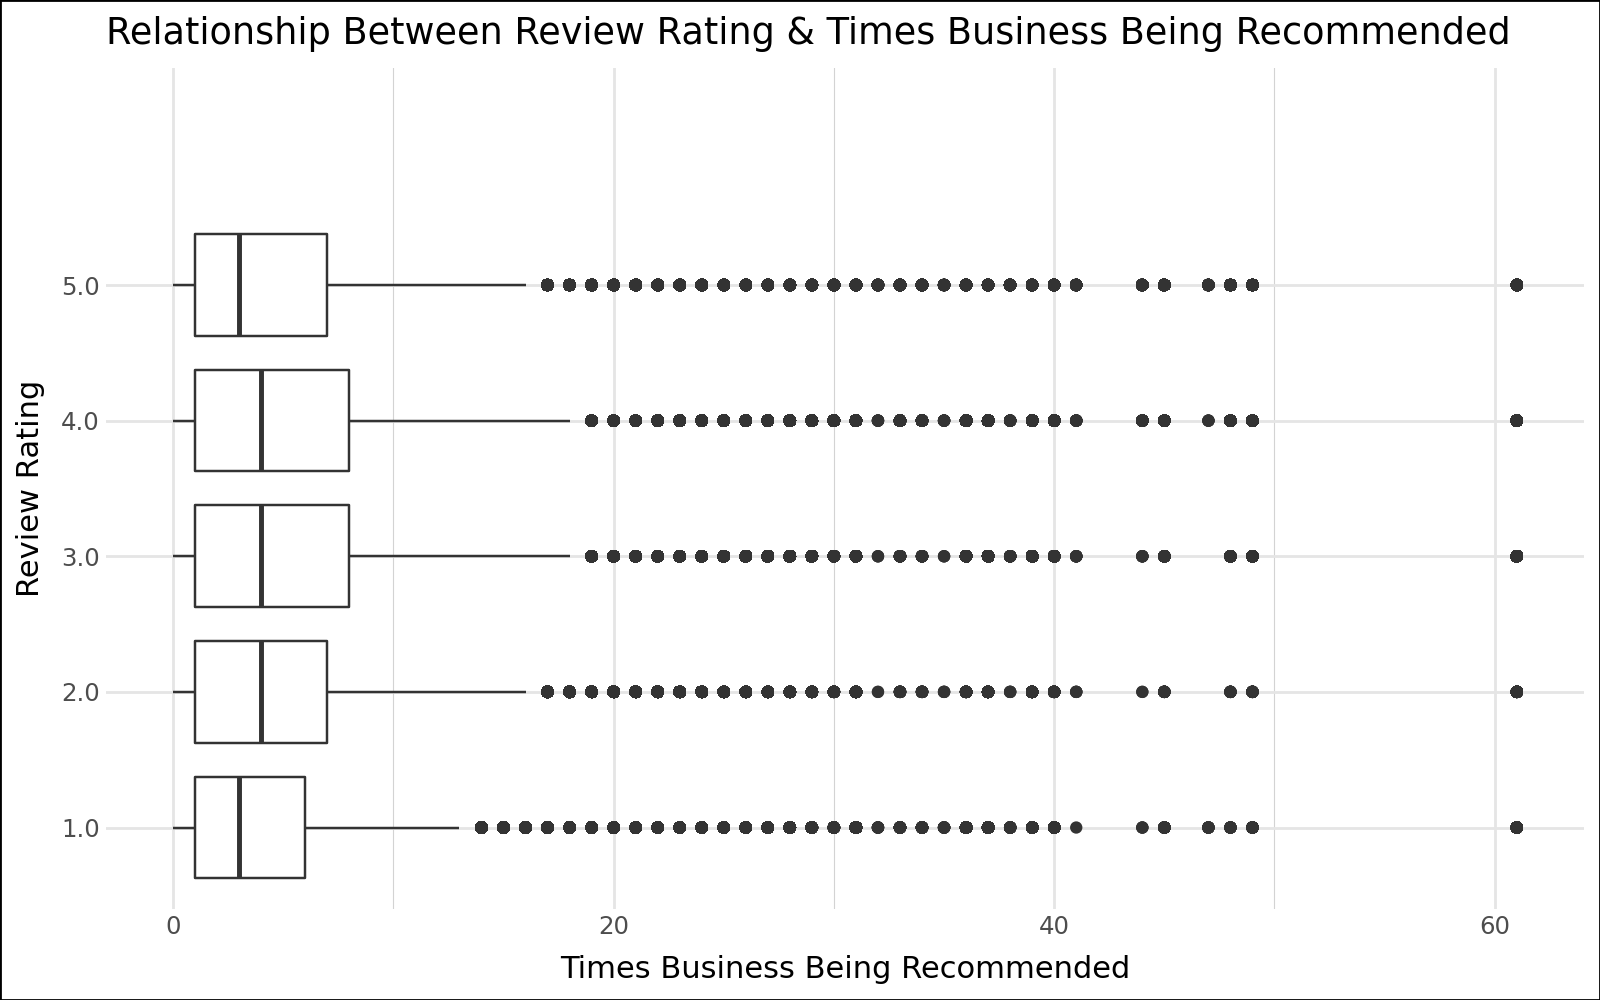

In [59]:
# Create a boxplot to visualize the distribution of review text length across different ratings
(ggplot(gmap_reviews, mapping=aes(x='factor(review_rating)', y='times_recommended')) +
    geom_boxplot() +  # Add a boxplot layer to the plot
    labs(
        title='Relationship Between Review Rating & Times Business Being Recommended',  # Add a title to the plot
        x='Review Rating',  # Label for the x-axis
        y='Times Business Being Recommended'  # Label for the y-axis
    ) +
    coord_flip() +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size=(8, 5),  # Set the size of the figure
        panel_background=element_rect(fill='white'),  # Set the panel background color to white
        plot_background=element_rect(fill='white'),  # Set the overall plot background color to white
        plot_title=element_text(hjust=0),  # Align the plot title to the left
        panel_grid_minor=element_line(color='lightgrey', size=0.4),  # Style the minor grid lines
    )
)

Chart 1 shows even though the number of times a business is recommended increases, it does not lead to a significant improvement in user ratings.

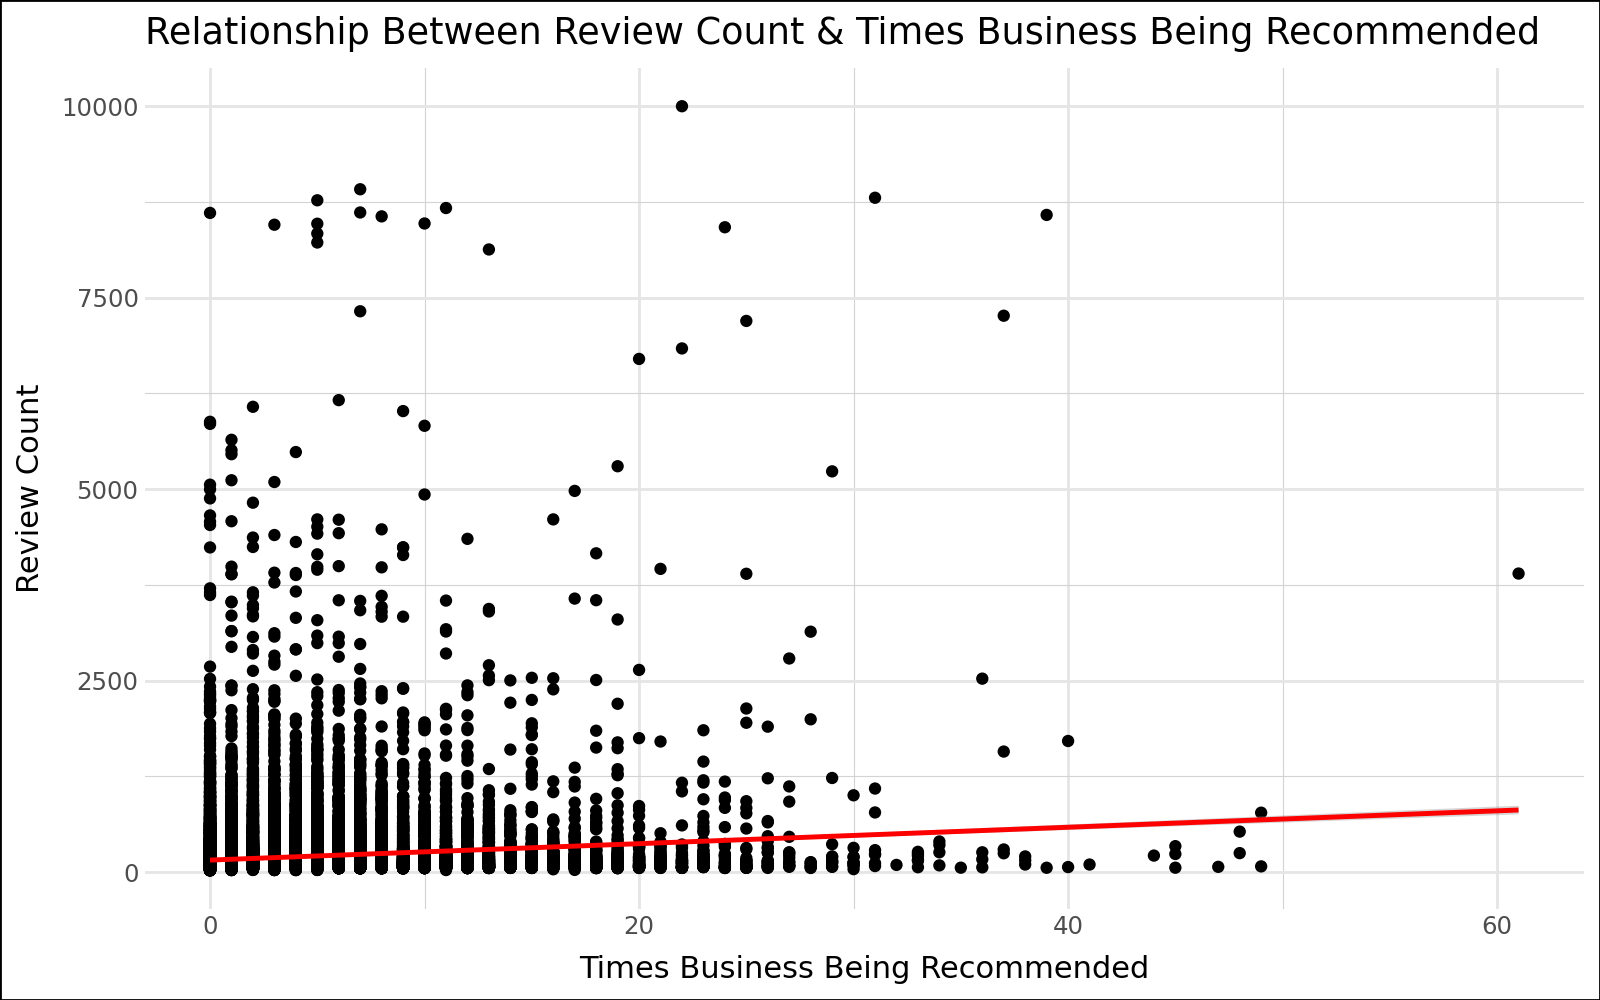

In [60]:
# Create a boxplot to visualize the distribution of review text length across different ratings
(ggplot(gmap_info, mapping=aes(x='times_recommended', y='review_count')) +
    geom_point() +  # Add a boxplot layer to the plot
    geom_smooth(color='red') +
    labs(
        title='Relationship Between Review Count & Times Business Being Recommended',  # Add a title to the plot
        x='Times Business Being Recommended',  # Label for the x-axis
        y='Review Count'  # Label for the y-axis
    ) +
    theme_minimal() +  # Apply a minimalistic theme to the plot
    theme(
        figure_size=(8, 5),  # Set the size of the figure
        panel_background=element_rect(fill='white'),  # Set the panel background color to white
        plot_background=element_rect(fill='white'),  # Set the overall plot background color to white
        plot_title=element_text(hjust=0),  # Align the plot title to the left
        panel_grid_minor=element_line(color='lightgrey', size=0.4),  # Style the minor grid lines
    )
)

Chart 2 shows more recommendations do not result in increased customer traffic.

## Conclusion

The analysis shows that user engagement on Google Map is closely to daily routines, with review activity peaking outside of working hours. 

While businesses with longer operating hours and more days tend to be more accessible, but this does not significantly boost foot traffic or improve ratings. 

Additionally, customer traffic varies by city and price level, highlighting the importance of these factors.

A key finding is the average user leaves only 1.1 reviews, indicating a lack of social interaction on the platform. This limits the effectiveness of Google Map recommendation system in driving customer traffic. Future research could explore additional factors affecting business success and consider ways to enhance the platform's social features.